In [17]:
import math
import numpy as np
from numpy.random import seed
import random
import pandas as pd

import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight

import tensorflow as tf
import tensorflow.keras.utils as Utils
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras import utils as np_utils

In [18]:
# Para reproduzir resultados em todas as execuções
# Seed Everything to reproduce results for future use cases
def seed_everything(seed=42):
    # Seed value for TensorFlow
    tf.random.set_seed(seed)
    
    # Seed value for NumPy
    np.random.seed(seed)
    
    # Seed value for Python's random library
    random.seed(seed)
    
    # Force TensorFlow to use single thread
    # Multiple threads are a potential source of non-reproducible results.
    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1
    )

    # Make sure that TensorFlow uses a deterministic operation wherever possible
    tf.compat.v1.set_random_seed(seed)

    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

seed_everything()

In [19]:
#importar funções
from global_functions import *

## Configurar e carregar imagens para treino dos modelos

In [20]:
#Treinar apenas as emoções presentes em todos os datasets (treino e teste)
emotions_labels = {0:'raiva',  1:'medo', 2:'alegria', 3: 'tristeza'}
class_names = ['raiva', 'medo', 'alegria', 'tristeza']

In [21]:
img_width = 224
img_height = 224
img_depth = 3
num_classes = len(class_names)
print('Classes:' + str(num_classes))

Classes:4


In [22]:
#emotions_labels = {0:'raiva', 1:'aversão', 2:'medo', 3:'alegria', 4: 'tristeza', 5: 'surpresa', 6: 'desprezo'}
#imagens lidas a partir dos diretórios <dataset>_<emotion>, por exemplo, NIMH_Angry (emotion:[Angry, Happy, Sad, Fear])
#imagens RECORTADAS lidas a partir dos diretórios <dataset>_<emotion>_cropped, por exemplo, NIMH_Angry (emotion:[Angry, Happy, Sad, Fear])

#Substituir DATASET por um dos datasets (CK, DEFSS, DEFSS18, FACES, NIMH, MUG)
DATASET = DATASET
filesStru = getFiles(dataset=DATASET, crop=True, extensao='jpg')

files = filesStru.files
files_class = filesStru.files_class

Raiva: 52
Medo: 52
Alegria: 52
Tristeza: 51
Total imagens: 207
Total classes: 207


In [23]:
#quantidade de imagens por emoção
data = {'imagem': files, 'emocao': files_class}
df = pd.DataFrame(data)
df['emocao'].value_counts().sort_index(ascending=True)

0    52
1    52
2    52
3    51
Name: emocao, dtype: int64

In [24]:
#percentagem de imagens por emoção
df['emocao'].value_counts(normalize=True, ascending=False) #.sort_index(ascending=True)

0    0.251208
1    0.251208
2    0.251208
3    0.246377
Name: emocao, dtype: float64

<AxesSubplot:>

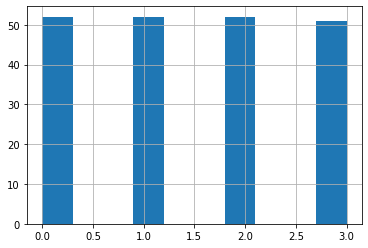

In [25]:
df['emocao'].hist()

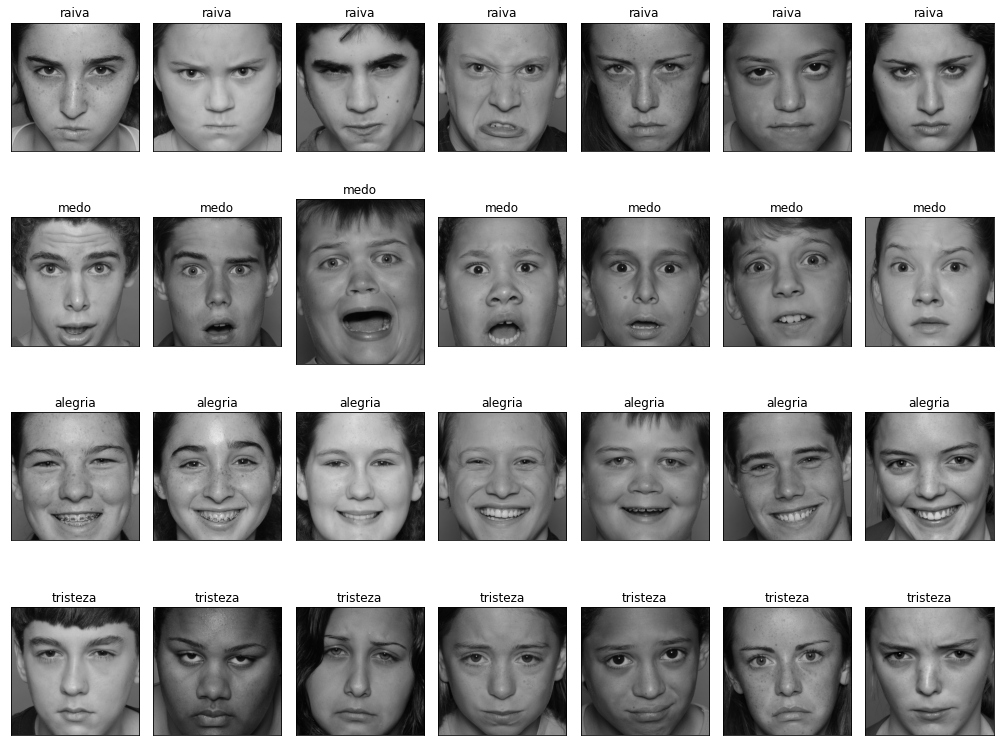

In [26]:
#Exibição de algumas das imagens após tratadas
some_images(files, files_class, emotions_labels)

In [11]:
#all_images(files, files_class, emotions_labels)

In [27]:
img_features_source = []
img_features_source = create_features(files, img_width, img_height)

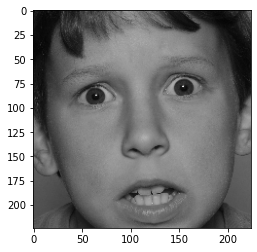

In [28]:
#Exibir uma imagem do img_features
pyplot.imshow(img_features_source[93].astype(np.uint8));

In [30]:
img_labels = np_utils.to_categorical(files_class,num_classes)
img_labels.shape

(207, 4)

## Dividir dados em Treino (treino e validação) e teste 

In [31]:
## Dividir os dados em treino e validação
X_train, X_test, y_train, y_test = train_test_split(img_features_source, img_labels, shuffle = True, 
                                                      stratify = img_labels, test_size = 0.20, random_state = 42)

X_train, X_valid, y_train, y_valid  = train_test_split(X_train, y_train, shuffle = True, 
                       test_size = 0.25, random_state = 42)
                       
X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape
        
np.save('X_test_' + DATASET + '.npy', X_test) #salvar dados teste 
np.save('Y_test_' + DATASET + '.npy', y_test) 

print(X_train.shape, X_test.shape, X_valid.shape)

(123, 224, 224, 3) (42, 224, 224, 3) (42, 224, 224, 3)


In [32]:
#Criando ImageDataGenerator para augmentation durante o treino
batchSize = 20
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   horizontal_flip = True,
                                   brightness_range=[0.5,1.5]
)

train_datagen.fit(X_train)

valid_datagen = ImageDataGenerator(rescale=1.0/255,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   horizontal_flip = True,
                                   brightness_range=[0.5,1.5]
)

valid_datagen.fit(X_valid)

train_generator = train_datagen.flow(X_train, y_train, batch_size = batchSize)
valid_generator = train_datagen.flow(X_valid, y_valid, batch_size = batchSize)

## Calcular pesos (desbalanceamento classes)

In [33]:
from sklearn.utils import class_weight
classes_train = np.argmax(y_train, axis=1)
classes = np.unique(classes_train)
weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(classes_train), y=classes_train)
weights = np.round(weights,6)
class_weights = {k: v for k, v in zip(classes, weights)}
print('Class weights:', class_weights)

Class weights: {0: 1.060345, 1: 0.904412, 2: 1.025, 3: 1.025}


## Criar modelos e treinar com classes adicionadas

### DenseNet121 - M1

In [34]:
 model = createModel('DenseNet121', img_height, img_width, modelType='m1', num_classes=4)

Model: "model"
_____________________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  Trainable  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            N          
                                                                                                             
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             N          
 g2D)                                                                                                        
                                                                                                             
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      N          
                                                                                                         

 rmalization)                                                       ']                                       
                                                                                                             
 conv2_block3_1_relu (Activ  (None, 56, 56, 128)          0         ['conv2_block3_1_bn[0][0]']   N          
 ation)                                                                                                      
                                                                                                             
 conv2_block3_2_conv (Conv2  (None, 56, 56, 32)           36864     ['conv2_block3_1_relu[0][0]   N          
 D)                                                                 ']                                       
                                                                                                             
 conv2_block3_concat (Conca  (None, 56, 56, 160)          0         ['conv2_block2_concat[0][0]   N          
 tenate)  

 D)                                                                 ']                                       
                                                                                                             
 conv2_block6_concat (Conca  (None, 56, 56, 256)          0         ['conv2_block5_concat[0][0]   N          
 tenate)                                                            ',                                       
                                                                     'conv2_block6_2_conv[0][0]              
                                                                    ']                                       
                                                                                                             
 pool2_bn (BatchNormalizati  (None, 56, 56, 256)          1024      ['conv2_block6_concat[0][0]   N          
 on)                                                                ']                                       
          

 ation)                                                                                                      
                                                                                                             
 conv3_block3_2_conv (Conv2  (None, 28, 28, 32)           36864     ['conv3_block3_1_relu[0][0]   N          
 D)                                                                 ']                                       
                                                                                                             
 conv3_block3_concat (Conca  (None, 28, 28, 224)          0         ['conv3_block2_concat[0][0]   N          
 tenate)                                                            ',                                       
                                                                     'conv3_block3_2_conv[0][0]              
                                                                    ']                                       
          

 tenate)                                                            ',                                       
                                                                     'conv3_block6_2_conv[0][0]              
                                                                    ']                                       
                                                                                                             
 conv3_block7_0_bn (BatchNo  (None, 28, 28, 320)          1280      ['conv3_block6_concat[0][0]   N          
 rmalization)                                                       ']                                       
                                                                                                             
 conv3_block7_0_relu (Activ  (None, 28, 28, 320)          0         ['conv3_block7_0_bn[0][0]']   N          
 ation)                                                                                                      
          

                                                                                                             
 conv3_block10_0_relu (Acti  (None, 28, 28, 416)          0         ['conv3_block10_0_bn[0][0]'   N          
 vation)                                                            ]                                        
                                                                                                             
 conv3_block10_1_conv (Conv  (None, 28, 28, 128)          53248     ['conv3_block10_0_relu[0][0   N          
 2D)                                                                ]']                                      
                                                                                                             
 conv3_block10_1_bn (BatchN  (None, 28, 28, 128)          512       ['conv3_block10_1_conv[0][0   N          
 ormalization)                                                      ]']                                      
          

 2D)                                                                                                         
                                                                                                             
 conv4_block1_0_bn (BatchNo  (None, 14, 14, 256)          1024      ['pool3_pool[0][0]']          N          
 rmalization)                                                                                                
                                                                                                             
 conv4_block1_0_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block1_0_bn[0][0]']   N          
 ation)                                                                                                      
                                                                                                             
 conv4_block1_1_conv (Conv2  (None, 14, 14, 128)          32768     ['conv4_block1_0_relu[0][0]   N          
 D)       

                                                                                                             
 conv4_block4_1_conv (Conv2  (None, 14, 14, 128)          45056     ['conv4_block4_0_relu[0][0]   N          
 D)                                                                 ']                                       
                                                                                                             
 conv4_block4_1_bn (BatchNo  (None, 14, 14, 128)          512       ['conv4_block4_1_conv[0][0]   N          
 rmalization)                                                       ']                                       
                                                                                                             
 conv4_block4_1_relu (Activ  (None, 14, 14, 128)          0         ['conv4_block4_1_bn[0][0]']   N          
 ation)                                                                                                      
          

                                                                                                             
 conv4_block7_1_relu (Activ  (None, 14, 14, 128)          0         ['conv4_block7_1_bn[0][0]']   N          
 ation)                                                                                                      
                                                                                                             
 conv4_block7_2_conv (Conv2  (None, 14, 14, 32)           36864     ['conv4_block7_1_relu[0][0]   N          
 D)                                                                 ']                                       
                                                                                                             
 conv4_block7_concat (Conca  (None, 14, 14, 480)          0         ['conv4_block6_concat[0][0]   N          
 tenate)                                                            ',                                       
          

                                                                                                             
 conv4_block10_concat (Conc  (None, 14, 14, 576)          0         ['conv4_block9_concat[0][0]   N          
 atenate)                                                           ',                                       
                                                                     'conv4_block10_2_conv[0][0              
                                                                    ]']                                      
                                                                                                             
 conv4_block11_0_bn (BatchN  (None, 14, 14, 576)          2304      ['conv4_block10_concat[0][0   N          
 ormalization)                                                      ]']                                      
                                                                                                             
 conv4_blo

 conv4_block14_0_bn (BatchN  (None, 14, 14, 672)          2688      ['conv4_block13_concat[0][0   N          
 ormalization)                                                      ]']                                      
                                                                                                             
 conv4_block14_0_relu (Acti  (None, 14, 14, 672)          0         ['conv4_block14_0_bn[0][0]'   N          
 vation)                                                            ]                                        
                                                                                                             
 conv4_block14_1_conv (Conv  (None, 14, 14, 128)          86016     ['conv4_block14_0_relu[0][0   N          
 2D)                                                                ]']                                      
                                                                                                             
 conv4_blo

 conv4_block17_1_conv (Conv  (None, 14, 14, 128)          98304     ['conv4_block17_0_relu[0][0   N          
 2D)                                                                ]']                                      
                                                                                                             
 conv4_block17_1_bn (BatchN  (None, 14, 14, 128)          512       ['conv4_block17_1_conv[0][0   N          
 ormalization)                                                      ]']                                      
                                                                                                             
 conv4_block17_1_relu (Acti  (None, 14, 14, 128)          0         ['conv4_block17_1_bn[0][0]'   N          
 vation)                                                            ]                                        
                                                                                                             
 conv4_blo

 conv4_block20_1_relu (Acti  (None, 14, 14, 128)          0         ['conv4_block20_1_bn[0][0]'   N          
 vation)                                                            ]                                        
                                                                                                             
 conv4_block20_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block20_1_relu[0][0   N          
 2D)                                                                ]']                                      
                                                                                                             
 conv4_block20_concat (Conc  (None, 14, 14, 896)          0         ['conv4_block19_concat[0][0   N          
 atenate)                                                           ]',                                      
                                                                     'conv4_block20_2_conv[0][0              
          

 conv4_block23_concat (Conc  (None, 14, 14, 992)          0         ['conv4_block22_concat[0][0   N          
 atenate)                                                           ]',                                      
                                                                     'conv4_block23_2_conv[0][0              
                                                                    ]']                                      
                                                                                                             
 conv4_block24_0_bn (BatchN  (None, 14, 14, 992)          3968      ['conv4_block23_concat[0][0   N          
 ormalization)                                                      ]']                                      
                                                                                                             
 conv4_block24_0_relu (Acti  (None, 14, 14, 992)          0         ['conv4_block24_0_bn[0][0]'   N          
 vation)  

 conv5_block2_2_conv (Conv2  (None, 7, 7, 32)             36864     ['conv5_block2_1_relu[0][0]   N          
 D)                                                                 ']                                       
                                                                                                             
 conv5_block2_concat (Conca  (None, 7, 7, 576)            0         ['conv5_block1_concat[0][0]   N          
 tenate)                                                            ',                                       
                                                                     'conv5_block2_2_conv[0][0]              
                                                                    ']                                       
                                                                                                             
 conv5_block3_0_bn (BatchNo  (None, 7, 7, 576)            2304      ['conv5_block2_concat[0][0]   N          
 rmalizati

                                                                    ']                                       
                                                                                                             
 conv5_block6_0_bn (BatchNo  (None, 7, 7, 672)            2688      ['conv5_block5_concat[0][0]   N          
 rmalization)                                                       ']                                       
                                                                                                             
 conv5_block6_0_relu (Activ  (None, 7, 7, 672)            0         ['conv5_block6_0_bn[0][0]']   N          
 ation)                                                                                                      
                                                                                                             
 conv5_block6_1_conv (Conv2  (None, 7, 7, 128)            86016     ['conv5_block6_0_relu[0][0]   N          
 D)       

 ation)                                                                                                      
                                                                                                             
 conv5_block9_1_conv (Conv2  (None, 7, 7, 128)            98304     ['conv5_block9_0_relu[0][0]   N          
 D)                                                                 ']                                       
                                                                                                             
 conv5_block9_1_bn (BatchNo  (None, 7, 7, 128)            512       ['conv5_block9_1_conv[0][0]   N          
 rmalization)                                                       ']                                       
                                                                                                             
 conv5_block9_1_relu (Activ  (None, 7, 7, 128)            0         ['conv5_block9_1_bn[0][0]']   N          
 ation)   

 ormalization)                                                      ]']                                      
                                                                                                             
 conv5_block12_1_relu (Acti  (None, 7, 7, 128)            0         ['conv5_block12_1_bn[0][0]'   N          
 vation)                                                            ]                                        
                                                                                                             
 conv5_block12_2_conv (Conv  (None, 7, 7, 32)             36864     ['conv5_block12_1_relu[0][0   N          
 2D)                                                                ]']                                      
                                                                                                             
 conv5_block12_concat (Conc  (None, 7, 7, 896)            0         ['conv5_block11_concat[0][0   N          
 atenate) 

 2D)                                                                ]']                                      
                                                                                                             
 conv5_block15_concat (Conc  (None, 7, 7, 992)            0         ['conv5_block14_concat[0][0   Y          
 atenate)                                                           ]',                                      
                                                                     'conv5_block15_2_conv[0][0              
                                                                    ]']                                      
                                                                                                             
 conv5_block16_0_bn (BatchN  (None, 7, 7, 992)            3968      ['conv5_block15_concat[0][0   N          
 ormalization)                                                      ]']                                      
          

Epoch 1/30
6/6 [==============================] - 16s 2s/step - loss: 1.3095 - accuracy: 0.3659 - val_loss: 1.2271 - val_accuracy: 0.4048 - lr: 1.0000e-04
Epoch 2/30
6/6 [==============================] - 12s 2s/step - loss: 1.2816 - accuracy: 0.4309 - val_loss: 1.1658 - val_accuracy: 0.5238 - lr: 1.0000e-04
Epoch 3/30
6/6 [==============================] - 13s 2s/step - loss: 1.2292 - accuracy: 0.4472 - val_loss: 1.1199 - val_accuracy: 0.6667 - lr: 1.0000e-04
Epoch 4/30
6/6 [==============================] - 12s 2s/step - loss: 1.1960 - accuracy: 0.4634 - val_loss: 0.9919 - val_accuracy: 0.7381 - lr: 1.0000e-04
Epoch 5/30
6/6 [==============================] - 12s 2s/step - loss: 1.0872 - accuracy: 0.5935 - val_loss: 0.9903 - val_accuracy: 0.6667 - lr: 1.0000e-04
Epoch 6/30
6/6 [==============================] - 12s 2s/step - loss: 1.0499 - accuracy: 0.5935 - val_loss: 0.9630 - val_accuracy: 0.7381 - lr: 1.0000e-04
Epoch 7/30
6/6 [==============================] - 13s 2s/step - loss: 

/home/s462321333/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


FileNotFoundError: [Errno 2] No such file or directory: 'resultados/epoch_history_DenseNet121_m1_NIMH.png'

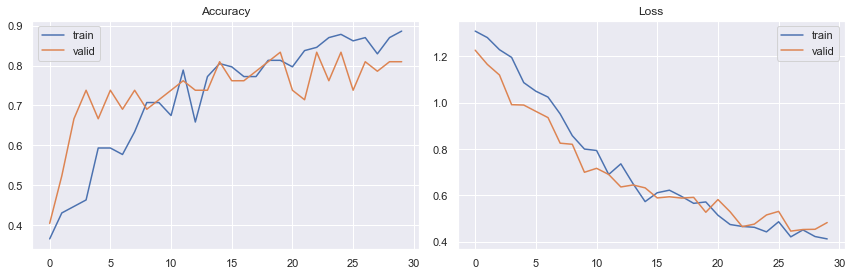

In [36]:
 modelTrained = compileAndTrain('DenseNet121', 'm1', DATASET, model, train_generator, valid_generator, X_train, class_weights) 

(42, 224, 224, 3) (42, 4)
2/2 [==============================] - 3s 615ms/step
total wrong validation predictions: 7


              precision    recall  f1-score   support

           0       0.89      0.73      0.80        11
           1       0.79      1.00      0.88        11
           2       1.00      1.00      1.00        10
           3       0.67      0.60      0.63        10

    accuracy                           0.83        42
   macro avg       0.84      0.83      0.83        42
weighted avg       0.84      0.83      0.83        42



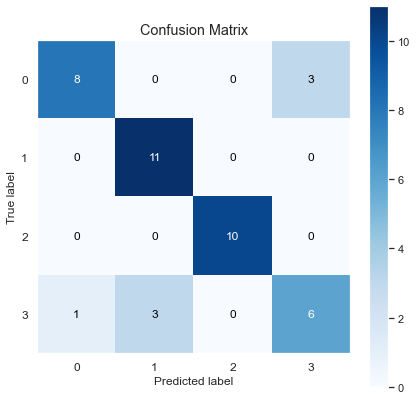

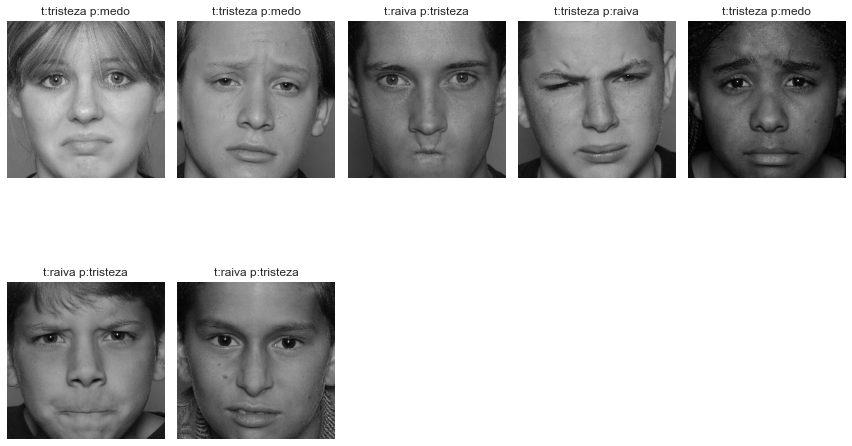

In [20]:
yhat = test_model('DenseNet121', 'm1', DATASET, modelTrained, X_test, y_test, emotions_labels)

### DenseNet121 - M2

In [21]:
model = createModel('DenseNet121', img_height, img_width, modelType='m2', num_classes=4)

Model: "model_1"
_____________________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  Trainable  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            N          
                                                                                                             
 zero_padding2d_2 (ZeroPadd  (None, 230, 230, 3)          0         ['input_2[0][0]']             N          
 ing2D)                                                                                                      
                                                                                                             
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_2[0][0]']    N          
                                                                                                       

 rmalization)                                                       ']                                       
                                                                                                             
 conv2_block3_1_relu (Activ  (None, 56, 56, 128)          0         ['conv2_block3_1_bn[0][0]']   N          
 ation)                                                                                                      
                                                                                                             
 conv2_block3_2_conv (Conv2  (None, 56, 56, 32)           36864     ['conv2_block3_1_relu[0][0]   N          
 D)                                                                 ']                                       
                                                                                                             
 conv2_block3_concat (Conca  (None, 56, 56, 160)          0         ['conv2_block2_concat[0][0]   N          
 tenate)  

 D)                                                                 ']                                       
                                                                                                             
 conv2_block6_concat (Conca  (None, 56, 56, 256)          0         ['conv2_block5_concat[0][0]   N          
 tenate)                                                            ',                                       
                                                                     'conv2_block6_2_conv[0][0]              
                                                                    ']                                       
                                                                                                             
 pool2_bn (BatchNormalizati  (None, 56, 56, 256)          1024      ['conv2_block6_concat[0][0]   N          
 on)                                                                ']                                       
          

 ation)                                                                                                      
                                                                                                             
 conv3_block3_2_conv (Conv2  (None, 28, 28, 32)           36864     ['conv3_block3_1_relu[0][0]   N          
 D)                                                                 ']                                       
                                                                                                             
 conv3_block3_concat (Conca  (None, 28, 28, 224)          0         ['conv3_block2_concat[0][0]   N          
 tenate)                                                            ',                                       
                                                                     'conv3_block3_2_conv[0][0]              
                                                                    ']                                       
          

 tenate)                                                            ',                                       
                                                                     'conv3_block6_2_conv[0][0]              
                                                                    ']                                       
                                                                                                             
 conv3_block7_0_bn (BatchNo  (None, 28, 28, 320)          1280      ['conv3_block6_concat[0][0]   N          
 rmalization)                                                       ']                                       
                                                                                                             
 conv3_block7_0_relu (Activ  (None, 28, 28, 320)          0         ['conv3_block7_0_bn[0][0]']   N          
 ation)                                                                                                      
          

                                                                                                             
 conv3_block10_0_relu (Acti  (None, 28, 28, 416)          0         ['conv3_block10_0_bn[0][0]'   N          
 vation)                                                            ]                                        
                                                                                                             
 conv3_block10_1_conv (Conv  (None, 28, 28, 128)          53248     ['conv3_block10_0_relu[0][0   N          
 2D)                                                                ]']                                      
                                                                                                             
 conv3_block10_1_bn (BatchN  (None, 28, 28, 128)          512       ['conv3_block10_1_conv[0][0   N          
 ormalization)                                                      ]']                                      
          

 2D)                                                                                                         
                                                                                                             
 conv4_block1_0_bn (BatchNo  (None, 14, 14, 256)          1024      ['pool3_pool[0][0]']          N          
 rmalization)                                                                                                
                                                                                                             
 conv4_block1_0_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block1_0_bn[0][0]']   N          
 ation)                                                                                                      
                                                                                                             
 conv4_block1_1_conv (Conv2  (None, 14, 14, 128)          32768     ['conv4_block1_0_relu[0][0]   N          
 D)       

                                                                                                             
 conv4_block4_1_conv (Conv2  (None, 14, 14, 128)          45056     ['conv4_block4_0_relu[0][0]   N          
 D)                                                                 ']                                       
                                                                                                             
 conv4_block4_1_bn (BatchNo  (None, 14, 14, 128)          512       ['conv4_block4_1_conv[0][0]   N          
 rmalization)                                                       ']                                       
                                                                                                             
 conv4_block4_1_relu (Activ  (None, 14, 14, 128)          0         ['conv4_block4_1_bn[0][0]']   N          
 ation)                                                                                                      
          

                                                                                                             
 conv4_block7_1_relu (Activ  (None, 14, 14, 128)          0         ['conv4_block7_1_bn[0][0]']   N          
 ation)                                                                                                      
                                                                                                             
 conv4_block7_2_conv (Conv2  (None, 14, 14, 32)           36864     ['conv4_block7_1_relu[0][0]   N          
 D)                                                                 ']                                       
                                                                                                             
 conv4_block7_concat (Conca  (None, 14, 14, 480)          0         ['conv4_block6_concat[0][0]   N          
 tenate)                                                            ',                                       
          

                                                                                                             
 conv4_block10_concat (Conc  (None, 14, 14, 576)          0         ['conv4_block9_concat[0][0]   N          
 atenate)                                                           ',                                       
                                                                     'conv4_block10_2_conv[0][0              
                                                                    ]']                                      
                                                                                                             
 conv4_block11_0_bn (BatchN  (None, 14, 14, 576)          2304      ['conv4_block10_concat[0][0   N          
 ormalization)                                                      ]']                                      
                                                                                                             
 conv4_blo

 conv4_block14_0_bn (BatchN  (None, 14, 14, 672)          2688      ['conv4_block13_concat[0][0   N          
 ormalization)                                                      ]']                                      
                                                                                                             
 conv4_block14_0_relu (Acti  (None, 14, 14, 672)          0         ['conv4_block14_0_bn[0][0]'   N          
 vation)                                                            ]                                        
                                                                                                             
 conv4_block14_1_conv (Conv  (None, 14, 14, 128)          86016     ['conv4_block14_0_relu[0][0   N          
 2D)                                                                ]']                                      
                                                                                                             
 conv4_blo

 conv4_block17_1_conv (Conv  (None, 14, 14, 128)          98304     ['conv4_block17_0_relu[0][0   N          
 2D)                                                                ]']                                      
                                                                                                             
 conv4_block17_1_bn (BatchN  (None, 14, 14, 128)          512       ['conv4_block17_1_conv[0][0   N          
 ormalization)                                                      ]']                                      
                                                                                                             
 conv4_block17_1_relu (Acti  (None, 14, 14, 128)          0         ['conv4_block17_1_bn[0][0]'   N          
 vation)                                                            ]                                        
                                                                                                             
 conv4_blo

 conv4_block20_1_relu (Acti  (None, 14, 14, 128)          0         ['conv4_block20_1_bn[0][0]'   N          
 vation)                                                            ]                                        
                                                                                                             
 conv4_block20_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block20_1_relu[0][0   N          
 2D)                                                                ]']                                      
                                                                                                             
 conv4_block20_concat (Conc  (None, 14, 14, 896)          0         ['conv4_block19_concat[0][0   N          
 atenate)                                                           ]',                                      
                                                                     'conv4_block20_2_conv[0][0              
          

 conv4_block23_concat (Conc  (None, 14, 14, 992)          0         ['conv4_block22_concat[0][0   N          
 atenate)                                                           ]',                                      
                                                                     'conv4_block23_2_conv[0][0              
                                                                    ]']                                      
                                                                                                             
 conv4_block24_0_bn (BatchN  (None, 14, 14, 992)          3968      ['conv4_block23_concat[0][0   N          
 ormalization)                                                      ]']                                      
                                                                                                             
 conv4_block24_0_relu (Acti  (None, 14, 14, 992)          0         ['conv4_block24_0_bn[0][0]'   N          
 vation)  

 conv5_block2_2_conv (Conv2  (None, 7, 7, 32)             36864     ['conv5_block2_1_relu[0][0]   N          
 D)                                                                 ']                                       
                                                                                                             
 conv5_block2_concat (Conca  (None, 7, 7, 576)            0         ['conv5_block1_concat[0][0]   N          
 tenate)                                                            ',                                       
                                                                     'conv5_block2_2_conv[0][0]              
                                                                    ']                                       
                                                                                                             
 conv5_block3_0_bn (BatchNo  (None, 7, 7, 576)            2304      ['conv5_block2_concat[0][0]   N          
 rmalizati

                                                                    ']                                       
                                                                                                             
 conv5_block6_0_bn (BatchNo  (None, 7, 7, 672)            2688      ['conv5_block5_concat[0][0]   N          
 rmalization)                                                       ']                                       
                                                                                                             
 conv5_block6_0_relu (Activ  (None, 7, 7, 672)            0         ['conv5_block6_0_bn[0][0]']   N          
 ation)                                                                                                      
                                                                                                             
 conv5_block6_1_conv (Conv2  (None, 7, 7, 128)            86016     ['conv5_block6_0_relu[0][0]   N          
 D)       

 ation)                                                                                                      
                                                                                                             
 conv5_block9_1_conv (Conv2  (None, 7, 7, 128)            98304     ['conv5_block9_0_relu[0][0]   N          
 D)                                                                 ']                                       
                                                                                                             
 conv5_block9_1_bn (BatchNo  (None, 7, 7, 128)            512       ['conv5_block9_1_conv[0][0]   N          
 rmalization)                                                       ']                                       
                                                                                                             
 conv5_block9_1_relu (Activ  (None, 7, 7, 128)            0         ['conv5_block9_1_bn[0][0]']   N          
 ation)   

 ormalization)                                                      ]']                                      
                                                                                                             
 conv5_block12_1_relu (Acti  (None, 7, 7, 128)            0         ['conv5_block12_1_bn[0][0]'   N          
 vation)                                                            ]                                        
                                                                                                             
 conv5_block12_2_conv (Conv  (None, 7, 7, 32)             36864     ['conv5_block12_1_relu[0][0   N          
 2D)                                                                ]']                                      
                                                                                                             
 conv5_block12_concat (Conc  (None, 7, 7, 896)            0         ['conv5_block11_concat[0][0   N          
 atenate) 

 2D)                                                                ]']                                      
                                                                                                             
 conv5_block15_concat (Conc  (None, 7, 7, 992)            0         ['conv5_block14_concat[0][0   Y          
 atenate)                                                           ]',                                      
                                                                     'conv5_block15_2_conv[0][0              
                                                                    ]']                                      
                                                                                                             
 conv5_block16_0_bn (BatchN  (None, 7, 7, 992)            3968      ['conv5_block15_concat[0][0   N          
 ormalization)                                                      ]']                                      
          

Epoch 1/30
6/6 [==============================] - 15s 2s/step - loss: 1.4101 - accuracy: 0.2927 - val_loss: 1.3918 - val_accuracy: 0.2619 - lr: 1.0000e-04
Epoch 2/30
6/6 [==============================] - 10s 2s/step - loss: 1.2916 - accuracy: 0.4146 - val_loss: 1.3855 - val_accuracy: 0.2619 - lr: 1.0000e-04
Epoch 3/30
6/6 [==============================] - 10s 2s/step - loss: 1.2806 - accuracy: 0.4390 - val_loss: 1.3804 - val_accuracy: 0.2619 - lr: 1.0000e-04
Epoch 4/30
6/6 [==============================] - 10s 2s/step - loss: 1.2291 - accuracy: 0.4472 - val_loss: 1.3875 - val_accuracy: 0.2619 - lr: 1.0000e-04
Epoch 5/30
6/6 [==============================] - 10s 2s/step - loss: 1.1717 - accuracy: 0.5122 - val_loss: 1.3768 - val_accuracy: 0.2619 - lr: 1.0000e-04
Epoch 6/30
6/6 [==============================] - 10s 2s/step - loss: 1.0915 - accuracy: 0.5691 - val_loss: 1.3688 - val_accuracy: 0.2619 - lr: 1.0000e-04
Epoch 7/30
6/6 [==============================] - 10s 2s/step - loss: 

/home/s462321333/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


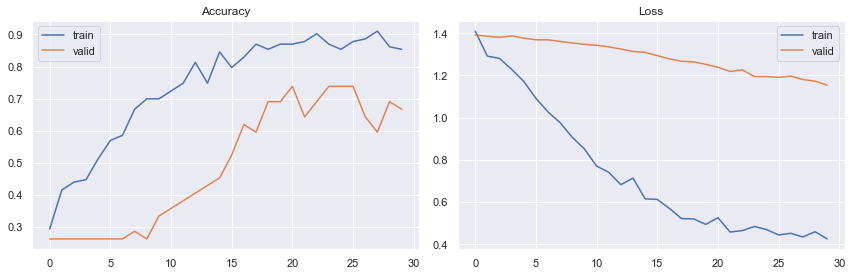

In [22]:
modelTrained = compileAndTrain('DenseNet121', 'm2', DATASET, model, train_generator, valid_generator, 
                                X_train, class_weights) 

(42, 224, 224, 3) (42, 4)
2/2 [==============================] - 4s 594ms/step
total wrong validation predictions: 16


              precision    recall  f1-score   support

           0       1.00      0.09      0.17        11
           1       0.73      1.00      0.85        11
           2       1.00      0.60      0.75        10
           3       0.40      0.80      0.53        10

    accuracy                           0.62        42
   macro avg       0.78      0.62      0.57        42
weighted avg       0.79      0.62      0.57        42



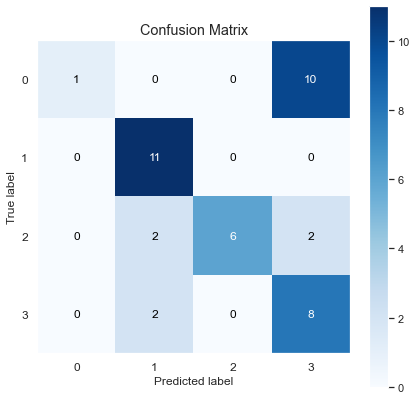

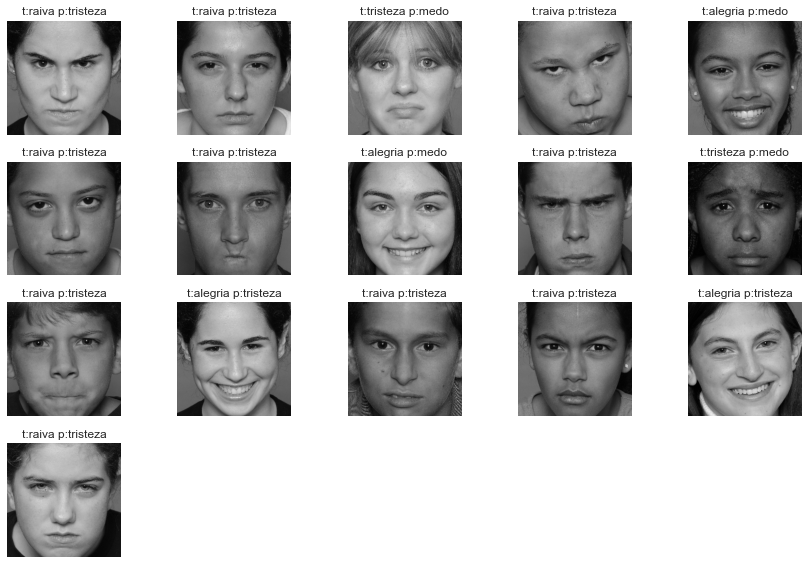

In [23]:
yhat = test_model('DenseNet121', 'm2', DATASET, modelTrained, X_test, y_test, emotions_labels)

### MobileNetV2 - M1

In [24]:
model = createModel('MobileNetV2', img_height, img_width, modelType='m1', num_classes=4)

Model: "model_2"
_____________________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  Trainable  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            N          
                                                                                                             
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_3[0][0]']             N          
                                                                                                             
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               N          
 on)                                                                                                         
                                                                                                       

                                                                                                             
 block_2_add (Add)           (None, 56, 56, 24)           0         ['block_1_project_BN[0][0]'   N          
                                                                    , 'block_2_project_BN[0][0]              
                                                                    ']                                       
                                                                                                             
 block_3_expand (Conv2D)     (None, 56, 56, 144)          3456      ['block_2_add[0][0]']         N          
                                                                                                             
 block_3_expand_BN (BatchNo  (None, 56, 56, 144)          576       ['block_3_expand[0][0]']      N          
 rmalization)                                                                                                
          

                                                                                                             
 block_5_project_BN (BatchN  (None, 28, 28, 32)           128       ['block_5_project[0][0]']     N          
 ormalization)                                                                                               
                                                                                                             
 block_5_add (Add)           (None, 28, 28, 32)           0         ['block_4_add[0][0]',         N          
                                                                     'block_5_project_BN[0][0]'              
                                                                    ]                                        
                                                                                                             
 block_6_expand (Conv2D)     (None, 28, 28, 192)          6144      ['block_5_add[0][0]']         N          
          

                                                                                                             
 block_8_project (Conv2D)    (None, 14, 14, 64)           24576     ['block_8_depthwise_relu[0]   N          
                                                                    [0]']                                    
                                                                                                             
 block_8_project_BN (BatchN  (None, 14, 14, 64)           256       ['block_8_project[0][0]']     N          
 ormalization)                                                                                               
                                                                                                             
 block_8_add (Add)           (None, 14, 14, 64)           0         ['block_7_add[0][0]',         N          
                                                                     'block_8_project_BN[0][0]'              
          

 block_11_depthwise_relu (R  (None, 14, 14, 576)          0         ['block_11_depthwise_BN[0][   N          
 eLU)                                                               0]']                                     
                                                                                                             
 block_11_project (Conv2D)   (None, 14, 14, 96)           55296     ['block_11_depthwise_relu[0   N          
                                                                    ][0]']                                   
                                                                                                             
 block_11_project_BN (Batch  (None, 14, 14, 96)           384       ['block_11_project[0][0]']    N          
 Normalization)                                                                                              
                                                                                                             
 block_11_

                                                                                                             
 block_14_depthwise (Depthw  (None, 7, 7, 960)            8640      ['block_14_expand_relu[0][0   N          
 iseConv2D)                                                         ]']                                      
                                                                                                             
 block_14_depthwise_BN (Bat  (None, 7, 7, 960)            3840      ['block_14_depthwise[0][0]'   N          
 chNormalization)                                                   ]                                        
                                                                                                             
 block_14_depthwise_relu (R  (None, 7, 7, 960)            0         ['block_14_depthwise_BN[0][   N          
 eLU)                                                               0]']                                     
          

                                                                                                             
 dense_1 (Dense)             (None, 256)                  1605657   ['flatten_1[0][0]']           Y          
                                                          6                                                  
                                                                                                             
 dropout_1 (Dropout)         (None, 256)                  0         ['dense_1[0][0]']             Y          
                                                                                                             
 out_layer (Dense)           (None, 4)                    1028      ['dropout_1[0][0]']           Y          
                                                                                                             
Total params: 18310468 (69.85 MB)
Trainable params: 17090244 (65.19 MB)
Non-trainable params: 1220224 (4.65 MB)
________

Epoch 1/30
6/6 [==============================] - 5s 591ms/step - loss: 4.9195 - accuracy: 0.2602 - val_loss: 2.4104 - val_accuracy: 0.3571 - lr: 1.0000e-04
Epoch 2/30
6/6 [==============================] - 3s 479ms/step - loss: 3.3842 - accuracy: 0.3577 - val_loss: 1.4974 - val_accuracy: 0.5238 - lr: 1.0000e-04
Epoch 3/30
6/6 [==============================] - 3s 471ms/step - loss: 1.8218 - accuracy: 0.4959 - val_loss: 1.2892 - val_accuracy: 0.4762 - lr: 1.0000e-04
Epoch 4/30
6/6 [==============================] - 3s 473ms/step - loss: 1.5231 - accuracy: 0.4797 - val_loss: 1.0734 - val_accuracy: 0.5714 - lr: 1.0000e-04
Epoch 5/30
6/6 [==============================] - 3s 468ms/step - loss: 1.2832 - accuracy: 0.5610 - val_loss: 1.1714 - val_accuracy: 0.5238 - lr: 1.0000e-04
Epoch 6/30
6/6 [==============================] - 3s 471ms/step - loss: 1.4308 - accuracy: 0.5854 - val_loss: 1.1412 - val_accuracy: 0.5476 - lr: 1.0000e-04
Epoch 7/30
6/6 [==============================] - 3s 474ms

/home/s462321333/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


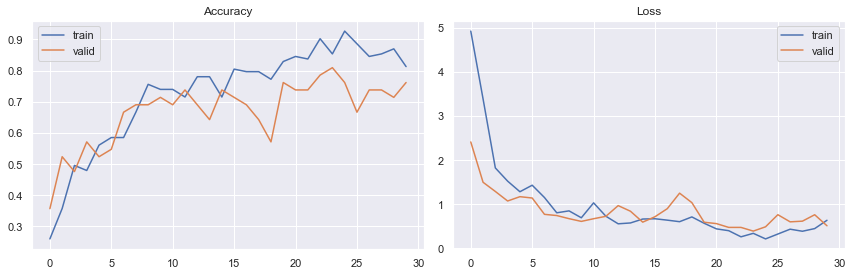

In [25]:
 modelTrained = compileAndTrain('MobileNetV2', 'm1', DATASET, model, train_generator, valid_generator, 
                                X_train, class_weights) 

(42, 224, 224, 3) (42, 4)
2/2 [==============================] - 1s 128ms/step
total wrong validation predictions: 10


              precision    recall  f1-score   support

           0       0.60      0.55      0.57        11
           1       1.00      0.91      0.95        11
           2       1.00      1.00      1.00        10
           3       0.50      0.60      0.55        10

    accuracy                           0.76        42
   macro avg       0.78      0.76      0.77        42
weighted avg       0.78      0.76      0.77        42



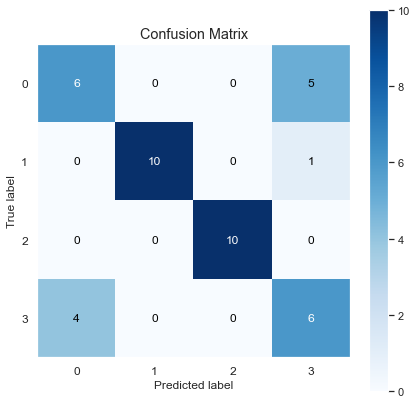

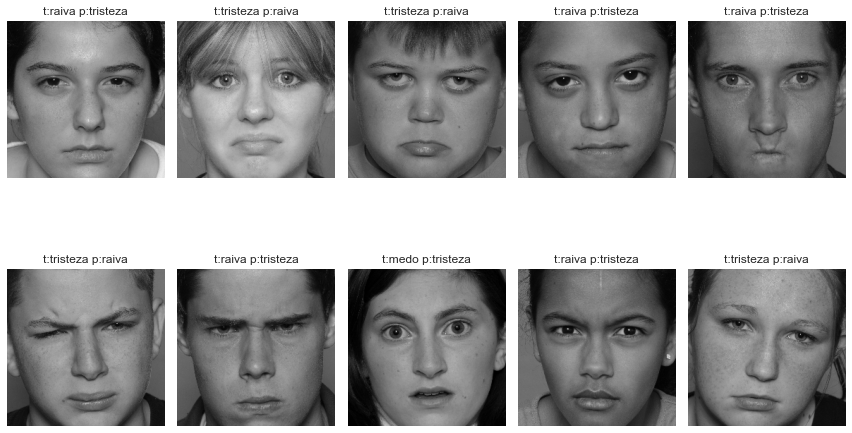

In [26]:
yhat = test_model('MobileNetV2', 'm1', DATASET, modelTrained, X_test, y_test, emotions_labels)

### MobileNetV2 - M2

In [27]:
model = createModel('MobileNetV2', img_height, img_width, modelType='m2', num_classes=4)

Model: "model_3"
_____________________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  Trainable  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            N          
                                                                                                             
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_4[0][0]']             N          
                                                                                                             
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               N          
 on)                                                                                                         
                                                                                                       

                                                                                                             
 block_2_add (Add)           (None, 56, 56, 24)           0         ['block_1_project_BN[0][0]'   N          
                                                                    , 'block_2_project_BN[0][0]              
                                                                    ']                                       
                                                                                                             
 block_3_expand (Conv2D)     (None, 56, 56, 144)          3456      ['block_2_add[0][0]']         N          
                                                                                                             
 block_3_expand_BN (BatchNo  (None, 56, 56, 144)          576       ['block_3_expand[0][0]']      N          
 rmalization)                                                                                                
          

                                                                                                             
 block_5_project_BN (BatchN  (None, 28, 28, 32)           128       ['block_5_project[0][0]']     N          
 ormalization)                                                                                               
                                                                                                             
 block_5_add (Add)           (None, 28, 28, 32)           0         ['block_4_add[0][0]',         N          
                                                                     'block_5_project_BN[0][0]'              
                                                                    ]                                        
                                                                                                             
 block_6_expand (Conv2D)     (None, 28, 28, 192)          6144      ['block_5_add[0][0]']         N          
          

                                                                                                             
 block_8_project (Conv2D)    (None, 14, 14, 64)           24576     ['block_8_depthwise_relu[0]   N          
                                                                    [0]']                                    
                                                                                                             
 block_8_project_BN (BatchN  (None, 14, 14, 64)           256       ['block_8_project[0][0]']     N          
 ormalization)                                                                                               
                                                                                                             
 block_8_add (Add)           (None, 14, 14, 64)           0         ['block_7_add[0][0]',         N          
                                                                     'block_8_project_BN[0][0]'              
          

 block_11_depthwise_relu (R  (None, 14, 14, 576)          0         ['block_11_depthwise_BN[0][   N          
 eLU)                                                               0]']                                     
                                                                                                             
 block_11_project (Conv2D)   (None, 14, 14, 96)           55296     ['block_11_depthwise_relu[0   N          
                                                                    ][0]']                                   
                                                                                                             
 block_11_project_BN (Batch  (None, 14, 14, 96)           384       ['block_11_project[0][0]']    N          
 Normalization)                                                                                              
                                                                                                             
 block_11_

                                                                                                             
 block_14_depthwise (Depthw  (None, 7, 7, 960)            8640      ['block_14_expand_relu[0][0   N          
 iseConv2D)                                                         ]']                                      
                                                                                                             
 block_14_depthwise_BN (Bat  (None, 7, 7, 960)            3840      ['block_14_depthwise[0][0]'   N          
 chNormalization)                                                   ]                                        
                                                                                                             
 block_14_depthwise_relu (R  (None, 7, 7, 960)            0         ['block_14_depthwise_BN[0][   N          
 eLU)                                                               0]']                                     
          

  (GlobalAveragePooling2D)                                                                                   
                                                                                                             
 batch_normalization_1 (Bat  (None, 1280)                 5120      ['global_average_pooling2d_   Y          
 chNormalization)                                                   1[0][0]']                                
                                                                                                             
 out_layer (Dense)           (None, 4)                    5124      ['batch_normalization_1[0][   Y          
                                                                    0]']                                     
                                                                                                             
Total params: 2263108 (8.63 MB)
Trainable params: 1040324 (3.97 MB)
Non-trainable params: 1222784 (4.66 MB)
____________

Epoch 1/30
6/6 [==============================] - 5s 513ms/step - loss: 1.3936 - accuracy: 0.4553 - val_loss: 1.9118 - val_accuracy: 0.2857 - lr: 1.0000e-04
Epoch 2/30
6/6 [==============================] - 3s 413ms/step - loss: 0.8820 - accuracy: 0.6260 - val_loss: 2.0968 - val_accuracy: 0.2857 - lr: 1.0000e-04
Epoch 3/30
6/6 [==============================] - 3s 406ms/step - loss: 0.5926 - accuracy: 0.7480 - val_loss: 2.1761 - val_accuracy: 0.3095 - lr: 1.0000e-04
Epoch 4/30
6/6 [==============================] - 2s 400ms/step - loss: 0.5065 - accuracy: 0.7967 - val_loss: 1.9072 - val_accuracy: 0.3333 - lr: 1.0000e-04
Epoch 5/30
6/6 [==============================] - 3s 404ms/step - loss: 0.4754 - accuracy: 0.7967 - val_loss: 1.5703 - val_accuracy: 0.3571 - lr: 1.0000e-04
Epoch 6/30
6/6 [==============================] - 2s 394ms/step - loss: 0.4449 - accuracy: 0.8374 - val_loss: 1.3387 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 7/30
6/6 [==============================] - 2s 404ms

/home/s462321333/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


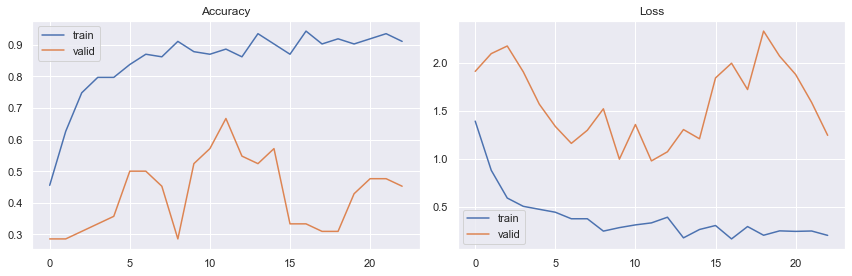

In [28]:
 modelTrained = compileAndTrain('MobileNetV2', 'm2', DATASET, model, train_generator, valid_generator, 
                                X_train, class_weights) 

(42, 224, 224, 3) (42, 4)
2/2 [==============================] - 1s 124ms/step
total wrong validation predictions: 8


              precision    recall  f1-score   support

           0       0.67      0.91      0.77        11
           1       0.85      1.00      0.92        11
           2       1.00      1.00      1.00        10
           3       0.75      0.30      0.43        10

    accuracy                           0.81        42
   macro avg       0.82      0.80      0.78        42
weighted avg       0.81      0.81      0.78        42



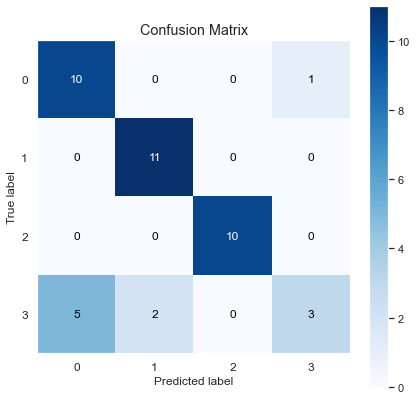

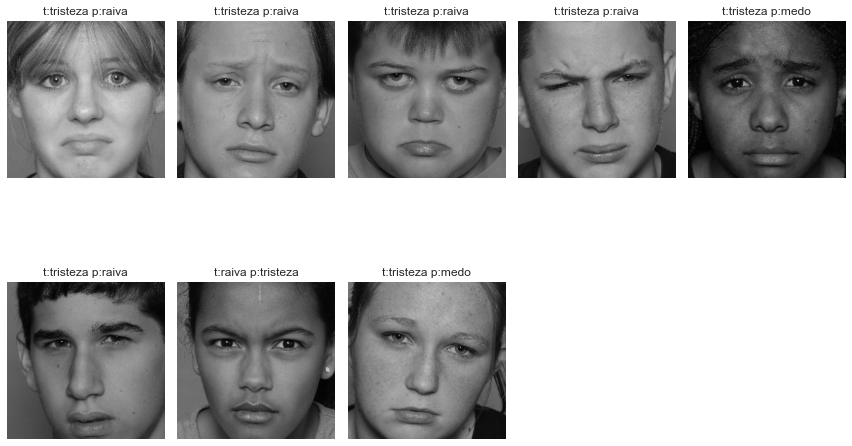

In [29]:
yhat = test_model('MobileNetV2', 'm2', DATASET, modelTrained, X_test, y_test, emotions_labels)

### DenseNet201 - M1

In [30]:
model = createModel('DenseNet201', img_height, img_width, modelType='m1', num_classes=4)

Model: "model_4"
_____________________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  Trainable  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            N          
                                                                                                             
 zero_padding2d_4 (ZeroPadd  (None, 230, 230, 3)          0         ['input_5[0][0]']             N          
 ing2D)                                                                                                      
                                                                                                             
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_4[0][0]']    N          
                                                                                                       

 rmalization)                                                       ']                                       
                                                                                                             
 conv2_block3_1_relu (Activ  (None, 56, 56, 128)          0         ['conv2_block3_1_bn[0][0]']   N          
 ation)                                                                                                      
                                                                                                             
 conv2_block3_2_conv (Conv2  (None, 56, 56, 32)           36864     ['conv2_block3_1_relu[0][0]   N          
 D)                                                                 ']                                       
                                                                                                             
 conv2_block3_concat (Conca  (None, 56, 56, 160)          0         ['conv2_block2_concat[0][0]   N          
 tenate)  

 D)                                                                 ']                                       
                                                                                                             
 conv2_block6_concat (Conca  (None, 56, 56, 256)          0         ['conv2_block5_concat[0][0]   N          
 tenate)                                                            ',                                       
                                                                     'conv2_block6_2_conv[0][0]              
                                                                    ']                                       
                                                                                                             
 pool2_bn (BatchNormalizati  (None, 56, 56, 256)          1024      ['conv2_block6_concat[0][0]   N          
 on)                                                                ']                                       
          

 ation)                                                                                                      
                                                                                                             
 conv3_block3_2_conv (Conv2  (None, 28, 28, 32)           36864     ['conv3_block3_1_relu[0][0]   N          
 D)                                                                 ']                                       
                                                                                                             
 conv3_block3_concat (Conca  (None, 28, 28, 224)          0         ['conv3_block2_concat[0][0]   N          
 tenate)                                                            ',                                       
                                                                     'conv3_block3_2_conv[0][0]              
                                                                    ']                                       
          

 tenate)                                                            ',                                       
                                                                     'conv3_block6_2_conv[0][0]              
                                                                    ']                                       
                                                                                                             
 conv3_block7_0_bn (BatchNo  (None, 28, 28, 320)          1280      ['conv3_block6_concat[0][0]   N          
 rmalization)                                                       ']                                       
                                                                                                             
 conv3_block7_0_relu (Activ  (None, 28, 28, 320)          0         ['conv3_block7_0_bn[0][0]']   N          
 ation)                                                                                                      
          

                                                                                                             
 conv3_block10_0_relu (Acti  (None, 28, 28, 416)          0         ['conv3_block10_0_bn[0][0]'   N          
 vation)                                                            ]                                        
                                                                                                             
 conv3_block10_1_conv (Conv  (None, 28, 28, 128)          53248     ['conv3_block10_0_relu[0][0   N          
 2D)                                                                ]']                                      
                                                                                                             
 conv3_block10_1_bn (BatchN  (None, 28, 28, 128)          512       ['conv3_block10_1_conv[0][0   N          
 ormalization)                                                      ]']                                      
          

 2D)                                                                                                         
                                                                                                             
 conv4_block1_0_bn (BatchNo  (None, 14, 14, 256)          1024      ['pool3_pool[0][0]']          N          
 rmalization)                                                                                                
                                                                                                             
 conv4_block1_0_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block1_0_bn[0][0]']   N          
 ation)                                                                                                      
                                                                                                             
 conv4_block1_1_conv (Conv2  (None, 14, 14, 128)          32768     ['conv4_block1_0_relu[0][0]   N          
 D)       

                                                                                                             
 conv4_block4_1_conv (Conv2  (None, 14, 14, 128)          45056     ['conv4_block4_0_relu[0][0]   N          
 D)                                                                 ']                                       
                                                                                                             
 conv4_block4_1_bn (BatchNo  (None, 14, 14, 128)          512       ['conv4_block4_1_conv[0][0]   N          
 rmalization)                                                       ']                                       
                                                                                                             
 conv4_block4_1_relu (Activ  (None, 14, 14, 128)          0         ['conv4_block4_1_bn[0][0]']   N          
 ation)                                                                                                      
          

                                                                                                             
 conv4_block7_1_relu (Activ  (None, 14, 14, 128)          0         ['conv4_block7_1_bn[0][0]']   N          
 ation)                                                                                                      
                                                                                                             
 conv4_block7_2_conv (Conv2  (None, 14, 14, 32)           36864     ['conv4_block7_1_relu[0][0]   N          
 D)                                                                 ']                                       
                                                                                                             
 conv4_block7_concat (Conca  (None, 14, 14, 480)          0         ['conv4_block6_concat[0][0]   N          
 tenate)                                                            ',                                       
          

                                                                                                             
 conv4_block10_concat (Conc  (None, 14, 14, 576)          0         ['conv4_block9_concat[0][0]   N          
 atenate)                                                           ',                                       
                                                                     'conv4_block10_2_conv[0][0              
                                                                    ]']                                      
                                                                                                             
 conv4_block11_0_bn (BatchN  (None, 14, 14, 576)          2304      ['conv4_block10_concat[0][0   N          
 ormalization)                                                      ]']                                      
                                                                                                             
 conv4_blo

 conv4_block14_0_bn (BatchN  (None, 14, 14, 672)          2688      ['conv4_block13_concat[0][0   N          
 ormalization)                                                      ]']                                      
                                                                                                             
 conv4_block14_0_relu (Acti  (None, 14, 14, 672)          0         ['conv4_block14_0_bn[0][0]'   N          
 vation)                                                            ]                                        
                                                                                                             
 conv4_block14_1_conv (Conv  (None, 14, 14, 128)          86016     ['conv4_block14_0_relu[0][0   N          
 2D)                                                                ]']                                      
                                                                                                             
 conv4_blo

 conv4_block17_1_conv (Conv  (None, 14, 14, 128)          98304     ['conv4_block17_0_relu[0][0   N          
 2D)                                                                ]']                                      
                                                                                                             
 conv4_block17_1_bn (BatchN  (None, 14, 14, 128)          512       ['conv4_block17_1_conv[0][0   N          
 ormalization)                                                      ]']                                      
                                                                                                             
 conv4_block17_1_relu (Acti  (None, 14, 14, 128)          0         ['conv4_block17_1_bn[0][0]'   N          
 vation)                                                            ]                                        
                                                                                                             
 conv4_blo

 conv4_block20_1_relu (Acti  (None, 14, 14, 128)          0         ['conv4_block20_1_bn[0][0]'   N          
 vation)                                                            ]                                        
                                                                                                             
 conv4_block20_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block20_1_relu[0][0   N          
 2D)                                                                ]']                                      
                                                                                                             
 conv4_block20_concat (Conc  (None, 14, 14, 896)          0         ['conv4_block19_concat[0][0   N          
 atenate)                                                           ]',                                      
                                                                     'conv4_block20_2_conv[0][0              
          

 conv4_block23_concat (Conc  (None, 14, 14, 992)          0         ['conv4_block22_concat[0][0   N          
 atenate)                                                           ]',                                      
                                                                     'conv4_block23_2_conv[0][0              
                                                                    ]']                                      
                                                                                                             
 conv4_block24_0_bn (BatchN  (None, 14, 14, 992)          3968      ['conv4_block23_concat[0][0   N          
 ormalization)                                                      ]']                                      
                                                                                                             
 conv4_block24_0_relu (Acti  (None, 14, 14, 992)          0         ['conv4_block24_0_bn[0][0]'   N          
 vation)  

 ormalization)                                                      ]']                                      
                                                                                                             
 conv4_block27_0_relu (Acti  (None, 14, 14, 1088)         0         ['conv4_block27_0_bn[0][0]'   N          
 vation)                                                            ]                                        
                                                                                                             
 conv4_block27_1_conv (Conv  (None, 14, 14, 128)          139264    ['conv4_block27_0_relu[0][0   N          
 2D)                                                                ]']                                      
                                                                                                             
 conv4_block27_1_bn (BatchN  (None, 14, 14, 128)          512       ['conv4_block27_1_conv[0][0   N          
 ormalizat

 2D)                                                                ]']                                      
                                                                                                             
 conv4_block30_1_bn (BatchN  (None, 14, 14, 128)          512       ['conv4_block30_1_conv[0][0   N          
 ormalization)                                                      ]']                                      
                                                                                                             
 conv4_block30_1_relu (Acti  (None, 14, 14, 128)          0         ['conv4_block30_1_bn[0][0]'   N          
 vation)                                                            ]                                        
                                                                                                             
 conv4_block30_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block30_1_relu[0][0   N          
 2D)      

 vation)                                                            ]                                        
                                                                                                             
 conv4_block33_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block33_1_relu[0][0   N          
 2D)                                                                ]']                                      
                                                                                                             
 conv4_block33_concat (Conc  (None, 14, 14, 1312)         0         ['conv4_block32_concat[0][0   N          
 atenate)                                                           ]',                                      
                                                                     'conv4_block33_2_conv[0][0              
                                                                    ]']                                      
          

 atenate)                                                           ]',                                      
                                                                     'conv4_block36_2_conv[0][0              
                                                                    ]']                                      
                                                                                                             
 conv4_block37_0_bn (BatchN  (None, 14, 14, 1408)         5632      ['conv4_block36_concat[0][0   N          
 ormalization)                                                      ]']                                      
                                                                                                             
 conv4_block37_0_relu (Acti  (None, 14, 14, 1408)         0         ['conv4_block37_0_bn[0][0]'   N          
 vation)                                                            ]                                        
          

                                                                                                             
 conv4_block40_0_relu (Acti  (None, 14, 14, 1504)         0         ['conv4_block40_0_bn[0][0]'   N          
 vation)                                                            ]                                        
                                                                                                             
 conv4_block40_1_conv (Conv  (None, 14, 14, 128)          192512    ['conv4_block40_0_relu[0][0   N          
 2D)                                                                ]']                                      
                                                                                                             
 conv4_block40_1_bn (BatchN  (None, 14, 14, 128)          512       ['conv4_block40_1_conv[0][0   N          
 ormalization)                                                      ]']                                      
          

                                                                                                             
 conv4_block43_1_bn (BatchN  (None, 14, 14, 128)          512       ['conv4_block43_1_conv[0][0   N          
 ormalization)                                                      ]']                                      
                                                                                                             
 conv4_block43_1_relu (Acti  (None, 14, 14, 128)          0         ['conv4_block43_1_bn[0][0]'   N          
 vation)                                                            ]                                        
                                                                                                             
 conv4_block43_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block43_1_relu[0][0   N          
 2D)                                                                ]']                                      
          

                                                                                                             
 conv4_block46_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block46_1_relu[0][0   N          
 2D)                                                                ]']                                      
                                                                                                             
 conv4_block46_concat (Conc  (None, 14, 14, 1728)         0         ['conv4_block45_concat[0][0   N          
 atenate)                                                           ]',                                      
                                                                     'conv4_block46_2_conv[0][0              
                                                                    ]']                                      
                                                                                                             
 conv4_blo

 rmalization)                                                       ']                                       
                                                                                                             
 conv5_block1_1_relu (Activ  (None, 7, 7, 128)            0         ['conv5_block1_1_bn[0][0]']   N          
 ation)                                                                                                      
                                                                                                             
 conv5_block1_2_conv (Conv2  (None, 7, 7, 32)             36864     ['conv5_block1_1_relu[0][0]   N          
 D)                                                                 ']                                       
                                                                                                             
 conv5_block1_concat (Conca  (None, 7, 7, 928)            0         ['pool4_pool[0][0]',          N          
 tenate)  

                                                                                                             
 conv5_block4_concat (Conca  (None, 7, 7, 1024)           0         ['conv5_block3_concat[0][0]   N          
 tenate)                                                            ',                                       
                                                                     'conv5_block4_2_conv[0][0]              
                                                                    ']                                       
                                                                                                             
 conv5_block5_0_bn (BatchNo  (None, 7, 7, 1024)           4096      ['conv5_block4_concat[0][0]   N          
 rmalization)                                                       ']                                       
                                                                                                             
 conv5_blo

 conv5_block8_0_bn (BatchNo  (None, 7, 7, 1120)           4480      ['conv5_block7_concat[0][0]   N          
 rmalization)                                                       ']                                       
                                                                                                             
 conv5_block8_0_relu (Activ  (None, 7, 7, 1120)           0         ['conv5_block8_0_bn[0][0]']   N          
 ation)                                                                                                      
                                                                                                             
 conv5_block8_1_conv (Conv2  (None, 7, 7, 128)            143360    ['conv5_block8_0_relu[0][0]   N          
 D)                                                                 ']                                       
                                                                                                             
 conv5_blo

 conv5_block11_1_conv (Conv  (None, 7, 7, 128)            155648    ['conv5_block11_0_relu[0][0   N          
 2D)                                                                ]']                                      
                                                                                                             
 conv5_block11_1_bn (BatchN  (None, 7, 7, 128)            512       ['conv5_block11_1_conv[0][0   N          
 ormalization)                                                      ]']                                      
                                                                                                             
 conv5_block11_1_relu (Acti  (None, 7, 7, 128)            0         ['conv5_block11_1_bn[0][0]'   N          
 vation)                                                            ]                                        
                                                                                                             
 conv5_blo

 conv5_block14_1_relu (Acti  (None, 7, 7, 128)            0         ['conv5_block14_1_bn[0][0]'   N          
 vation)                                                            ]                                        
                                                                                                             
 conv5_block14_2_conv (Conv  (None, 7, 7, 32)             36864     ['conv5_block14_1_relu[0][0   N          
 2D)                                                                ]']                                      
                                                                                                             
 conv5_block14_concat (Conc  (None, 7, 7, 1344)           0         ['conv5_block13_concat[0][0   N          
 atenate)                                                           ]',                                      
                                                                     'conv5_block14_2_conv[0][0              
          

 conv5_block17_concat (Conc  (None, 7, 7, 1440)           0         ['conv5_block16_concat[0][0   N          
 atenate)                                                           ]',                                      
                                                                     'conv5_block17_2_conv[0][0              
                                                                    ]']                                      
                                                                                                             
 conv5_block18_0_bn (BatchN  (None, 7, 7, 1440)           5760      ['conv5_block17_concat[0][0   N          
 ormalization)                                                      ]']                                      
                                                                                                             
 conv5_block18_0_relu (Acti  (None, 7, 7, 1440)           0         ['conv5_block18_0_bn[0][0]'   N          
 vation)  

 ormalization)                                                      ]']                                      
                                                                                                             
 conv5_block21_0_relu (Acti  (None, 7, 7, 1536)           0         ['conv5_block21_0_bn[0][0]'   N          
 vation)                                                            ]                                        
                                                                                                             
 conv5_block21_1_conv (Conv  (None, 7, 7, 128)            196608    ['conv5_block21_0_relu[0][0   N          
 2D)                                                                ]']                                      
                                                                                                             
 conv5_block21_1_bn (BatchN  (None, 7, 7, 128)            512       ['conv5_block21_1_conv[0][0   N          
 ormalizat

 2D)                                                                ]']                                      
                                                                                                             
 conv5_block24_1_bn (BatchN  (None, 7, 7, 128)            512       ['conv5_block24_1_conv[0][0   N          
 ormalization)                                                      ]']                                      
                                                                                                             
 conv5_block24_1_relu (Acti  (None, 7, 7, 128)            0         ['conv5_block24_1_bn[0][0]'   N          
 vation)                                                            ]                                        
                                                                                                             
 conv5_block24_2_conv (Conv  (None, 7, 7, 32)             36864     ['conv5_block24_1_relu[0][0   N          
 2D)      

 vation)                                                            ]                                        
                                                                                                             
 conv5_block27_2_conv (Conv  (None, 7, 7, 32)             36864     ['conv5_block27_1_relu[0][0   N          
 2D)                                                                ]']                                      
                                                                                                             
 conv5_block27_concat (Conc  (None, 7, 7, 1760)           0         ['conv5_block26_concat[0][0   N          
 atenate)                                                           ]',                                      
                                                                     'conv5_block27_2_conv[0][0              
                                                                    ]']                                      
          

 atenate)                                                           ]',                                      
                                                                     'conv5_block30_2_conv[0][0              
                                                                    ]']                                      
                                                                                                             
 conv5_block31_0_bn (BatchN  (None, 7, 7, 1856)           7424      ['conv5_block30_concat[0][0   N          
 ormalization)                                                      ]']                                      
                                                                                                             
 conv5_block31_0_relu (Acti  (None, 7, 7, 1856)           0         ['conv5_block31_0_bn[0][0]'   Y          
 vation)                                                            ]                                        
          

Epoch 1/30
6/6 [==============================] - 24s 3s/step - loss: 1.5597 - accuracy: 0.2358 - val_loss: 1.3906 - val_accuracy: 0.2619 - lr: 1.0000e-04
Epoch 2/30
6/6 [==============================] - 17s 3s/step - loss: 1.4656 - accuracy: 0.2602 - val_loss: 1.3261 - val_accuracy: 0.3810 - lr: 1.0000e-04
Epoch 3/30
6/6 [==============================] - 17s 3s/step - loss: 1.4311 - accuracy: 0.3333 - val_loss: 1.1992 - val_accuracy: 0.4286 - lr: 1.0000e-04
Epoch 4/30
6/6 [==============================] - 17s 3s/step - loss: 1.3227 - accuracy: 0.3902 - val_loss: 1.2594 - val_accuracy: 0.4524 - lr: 1.0000e-04
Epoch 5/30
6/6 [==============================] - 17s 3s/step - loss: 1.3392 - accuracy: 0.3496 - val_loss: 1.2547 - val_accuracy: 0.4524 - lr: 1.0000e-04
Epoch 6/30
6/6 [==============================] - 17s 3s/step - loss: 1.2181 - accuracy: 0.4878 - val_loss: 1.1358 - val_accuracy: 0.4524 - lr: 1.0000e-04
Epoch 7/30
6/6 [==============================] - 17s 3s/step - loss: 

/home/s462321333/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


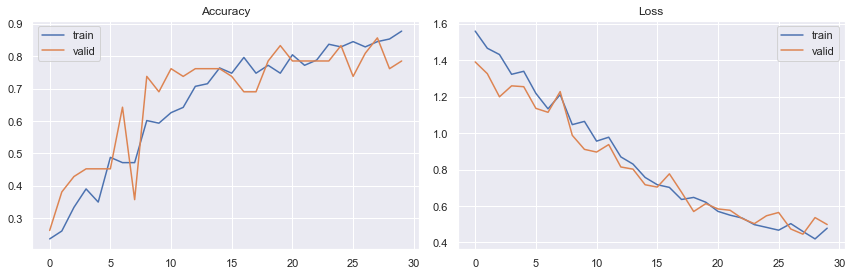

In [31]:
 modelTrained = compileAndTrain('DenseNet201', 'm1', DATASET, model, train_generator, valid_generator, 
                                X_train, class_weights) 

(42, 224, 224, 3) (42, 4)
2/2 [==============================] - 6s 1s/step
total wrong validation predictions: 6


              precision    recall  f1-score   support

           0       0.78      0.64      0.70        11
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00        10
           3       0.67      0.80      0.73        10

    accuracy                           0.86        42
   macro avg       0.86      0.86      0.86        42
weighted avg       0.86      0.86      0.86        42



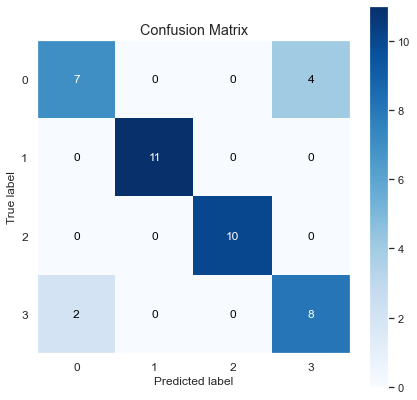

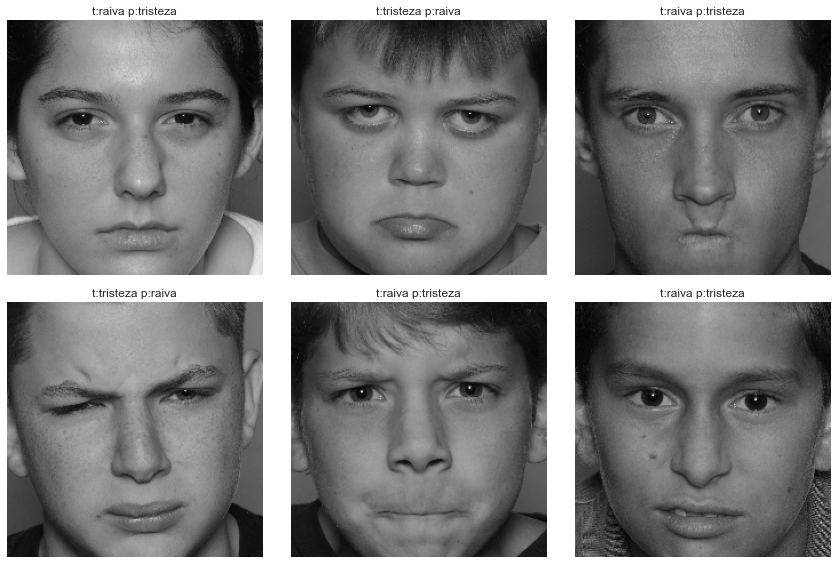

In [32]:
yhat = test_model('DenseNet201', 'm1', DATASET, modelTrained, X_test, y_test, emotions_labels)

### DenseNet201 - M2

In [33]:
model = createModel('DenseNet201', img_height, img_width, modelType='m2', num_classes=4)

Model: "model_5"
_____________________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  Trainable  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            N          
                                                                                                             
 zero_padding2d_6 (ZeroPadd  (None, 230, 230, 3)          0         ['input_6[0][0]']             N          
 ing2D)                                                                                                      
                                                                                                             
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_6[0][0]']    N          
                                                                                                       

 rmalization)                                                       ']                                       
                                                                                                             
 conv2_block3_1_relu (Activ  (None, 56, 56, 128)          0         ['conv2_block3_1_bn[0][0]']   N          
 ation)                                                                                                      
                                                                                                             
 conv2_block3_2_conv (Conv2  (None, 56, 56, 32)           36864     ['conv2_block3_1_relu[0][0]   N          
 D)                                                                 ']                                       
                                                                                                             
 conv2_block3_concat (Conca  (None, 56, 56, 160)          0         ['conv2_block2_concat[0][0]   N          
 tenate)  

 D)                                                                 ']                                       
                                                                                                             
 conv2_block6_concat (Conca  (None, 56, 56, 256)          0         ['conv2_block5_concat[0][0]   N          
 tenate)                                                            ',                                       
                                                                     'conv2_block6_2_conv[0][0]              
                                                                    ']                                       
                                                                                                             
 pool2_bn (BatchNormalizati  (None, 56, 56, 256)          1024      ['conv2_block6_concat[0][0]   N          
 on)                                                                ']                                       
          

 ation)                                                                                                      
                                                                                                             
 conv3_block3_2_conv (Conv2  (None, 28, 28, 32)           36864     ['conv3_block3_1_relu[0][0]   N          
 D)                                                                 ']                                       
                                                                                                             
 conv3_block3_concat (Conca  (None, 28, 28, 224)          0         ['conv3_block2_concat[0][0]   N          
 tenate)                                                            ',                                       
                                                                     'conv3_block3_2_conv[0][0]              
                                                                    ']                                       
          

 tenate)                                                            ',                                       
                                                                     'conv3_block6_2_conv[0][0]              
                                                                    ']                                       
                                                                                                             
 conv3_block7_0_bn (BatchNo  (None, 28, 28, 320)          1280      ['conv3_block6_concat[0][0]   N          
 rmalization)                                                       ']                                       
                                                                                                             
 conv3_block7_0_relu (Activ  (None, 28, 28, 320)          0         ['conv3_block7_0_bn[0][0]']   N          
 ation)                                                                                                      
          

                                                                                                             
 conv3_block10_0_relu (Acti  (None, 28, 28, 416)          0         ['conv3_block10_0_bn[0][0]'   N          
 vation)                                                            ]                                        
                                                                                                             
 conv3_block10_1_conv (Conv  (None, 28, 28, 128)          53248     ['conv3_block10_0_relu[0][0   N          
 2D)                                                                ]']                                      
                                                                                                             
 conv3_block10_1_bn (BatchN  (None, 28, 28, 128)          512       ['conv3_block10_1_conv[0][0   N          
 ormalization)                                                      ]']                                      
          

 2D)                                                                                                         
                                                                                                             
 conv4_block1_0_bn (BatchNo  (None, 14, 14, 256)          1024      ['pool3_pool[0][0]']          N          
 rmalization)                                                                                                
                                                                                                             
 conv4_block1_0_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block1_0_bn[0][0]']   N          
 ation)                                                                                                      
                                                                                                             
 conv4_block1_1_conv (Conv2  (None, 14, 14, 128)          32768     ['conv4_block1_0_relu[0][0]   N          
 D)       

                                                                                                             
 conv4_block4_1_conv (Conv2  (None, 14, 14, 128)          45056     ['conv4_block4_0_relu[0][0]   N          
 D)                                                                 ']                                       
                                                                                                             
 conv4_block4_1_bn (BatchNo  (None, 14, 14, 128)          512       ['conv4_block4_1_conv[0][0]   N          
 rmalization)                                                       ']                                       
                                                                                                             
 conv4_block4_1_relu (Activ  (None, 14, 14, 128)          0         ['conv4_block4_1_bn[0][0]']   N          
 ation)                                                                                                      
          

                                                                                                             
 conv4_block7_1_relu (Activ  (None, 14, 14, 128)          0         ['conv4_block7_1_bn[0][0]']   N          
 ation)                                                                                                      
                                                                                                             
 conv4_block7_2_conv (Conv2  (None, 14, 14, 32)           36864     ['conv4_block7_1_relu[0][0]   N          
 D)                                                                 ']                                       
                                                                                                             
 conv4_block7_concat (Conca  (None, 14, 14, 480)          0         ['conv4_block6_concat[0][0]   N          
 tenate)                                                            ',                                       
          

                                                                                                             
 conv4_block10_concat (Conc  (None, 14, 14, 576)          0         ['conv4_block9_concat[0][0]   N          
 atenate)                                                           ',                                       
                                                                     'conv4_block10_2_conv[0][0              
                                                                    ]']                                      
                                                                                                             
 conv4_block11_0_bn (BatchN  (None, 14, 14, 576)          2304      ['conv4_block10_concat[0][0   N          
 ormalization)                                                      ]']                                      
                                                                                                             
 conv4_blo

 conv4_block14_0_bn (BatchN  (None, 14, 14, 672)          2688      ['conv4_block13_concat[0][0   N          
 ormalization)                                                      ]']                                      
                                                                                                             
 conv4_block14_0_relu (Acti  (None, 14, 14, 672)          0         ['conv4_block14_0_bn[0][0]'   N          
 vation)                                                            ]                                        
                                                                                                             
 conv4_block14_1_conv (Conv  (None, 14, 14, 128)          86016     ['conv4_block14_0_relu[0][0   N          
 2D)                                                                ]']                                      
                                                                                                             
 conv4_blo

 conv4_block17_1_conv (Conv  (None, 14, 14, 128)          98304     ['conv4_block17_0_relu[0][0   N          
 2D)                                                                ]']                                      
                                                                                                             
 conv4_block17_1_bn (BatchN  (None, 14, 14, 128)          512       ['conv4_block17_1_conv[0][0   N          
 ormalization)                                                      ]']                                      
                                                                                                             
 conv4_block17_1_relu (Acti  (None, 14, 14, 128)          0         ['conv4_block17_1_bn[0][0]'   N          
 vation)                                                            ]                                        
                                                                                                             
 conv4_blo

 conv4_block20_1_relu (Acti  (None, 14, 14, 128)          0         ['conv4_block20_1_bn[0][0]'   N          
 vation)                                                            ]                                        
                                                                                                             
 conv4_block20_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block20_1_relu[0][0   N          
 2D)                                                                ]']                                      
                                                                                                             
 conv4_block20_concat (Conc  (None, 14, 14, 896)          0         ['conv4_block19_concat[0][0   N          
 atenate)                                                           ]',                                      
                                                                     'conv4_block20_2_conv[0][0              
          

 conv4_block23_concat (Conc  (None, 14, 14, 992)          0         ['conv4_block22_concat[0][0   N          
 atenate)                                                           ]',                                      
                                                                     'conv4_block23_2_conv[0][0              
                                                                    ]']                                      
                                                                                                             
 conv4_block24_0_bn (BatchN  (None, 14, 14, 992)          3968      ['conv4_block23_concat[0][0   N          
 ormalization)                                                      ]']                                      
                                                                                                             
 conv4_block24_0_relu (Acti  (None, 14, 14, 992)          0         ['conv4_block24_0_bn[0][0]'   N          
 vation)  

 ormalization)                                                      ]']                                      
                                                                                                             
 conv4_block27_0_relu (Acti  (None, 14, 14, 1088)         0         ['conv4_block27_0_bn[0][0]'   N          
 vation)                                                            ]                                        
                                                                                                             
 conv4_block27_1_conv (Conv  (None, 14, 14, 128)          139264    ['conv4_block27_0_relu[0][0   N          
 2D)                                                                ]']                                      
                                                                                                             
 conv4_block27_1_bn (BatchN  (None, 14, 14, 128)          512       ['conv4_block27_1_conv[0][0   N          
 ormalizat

 2D)                                                                ]']                                      
                                                                                                             
 conv4_block30_1_bn (BatchN  (None, 14, 14, 128)          512       ['conv4_block30_1_conv[0][0   N          
 ormalization)                                                      ]']                                      
                                                                                                             
 conv4_block30_1_relu (Acti  (None, 14, 14, 128)          0         ['conv4_block30_1_bn[0][0]'   N          
 vation)                                                            ]                                        
                                                                                                             
 conv4_block30_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block30_1_relu[0][0   N          
 2D)      

 vation)                                                            ]                                        
                                                                                                             
 conv4_block33_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block33_1_relu[0][0   N          
 2D)                                                                ]']                                      
                                                                                                             
 conv4_block33_concat (Conc  (None, 14, 14, 1312)         0         ['conv4_block32_concat[0][0   N          
 atenate)                                                           ]',                                      
                                                                     'conv4_block33_2_conv[0][0              
                                                                    ]']                                      
          

 atenate)                                                           ]',                                      
                                                                     'conv4_block36_2_conv[0][0              
                                                                    ]']                                      
                                                                                                             
 conv4_block37_0_bn (BatchN  (None, 14, 14, 1408)         5632      ['conv4_block36_concat[0][0   N          
 ormalization)                                                      ]']                                      
                                                                                                             
 conv4_block37_0_relu (Acti  (None, 14, 14, 1408)         0         ['conv4_block37_0_bn[0][0]'   N          
 vation)                                                            ]                                        
          

                                                                                                             
 conv4_block40_0_relu (Acti  (None, 14, 14, 1504)         0         ['conv4_block40_0_bn[0][0]'   N          
 vation)                                                            ]                                        
                                                                                                             
 conv4_block40_1_conv (Conv  (None, 14, 14, 128)          192512    ['conv4_block40_0_relu[0][0   N          
 2D)                                                                ]']                                      
                                                                                                             
 conv4_block40_1_bn (BatchN  (None, 14, 14, 128)          512       ['conv4_block40_1_conv[0][0   N          
 ormalization)                                                      ]']                                      
          

                                                                                                             
 conv4_block43_1_bn (BatchN  (None, 14, 14, 128)          512       ['conv4_block43_1_conv[0][0   N          
 ormalization)                                                      ]']                                      
                                                                                                             
 conv4_block43_1_relu (Acti  (None, 14, 14, 128)          0         ['conv4_block43_1_bn[0][0]'   N          
 vation)                                                            ]                                        
                                                                                                             
 conv4_block43_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block43_1_relu[0][0   N          
 2D)                                                                ]']                                      
          

                                                                                                             
 conv4_block46_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block46_1_relu[0][0   N          
 2D)                                                                ]']                                      
                                                                                                             
 conv4_block46_concat (Conc  (None, 14, 14, 1728)         0         ['conv4_block45_concat[0][0   N          
 atenate)                                                           ]',                                      
                                                                     'conv4_block46_2_conv[0][0              
                                                                    ]']                                      
                                                                                                             
 conv4_blo

 rmalization)                                                       ']                                       
                                                                                                             
 conv5_block1_1_relu (Activ  (None, 7, 7, 128)            0         ['conv5_block1_1_bn[0][0]']   N          
 ation)                                                                                                      
                                                                                                             
 conv5_block1_2_conv (Conv2  (None, 7, 7, 32)             36864     ['conv5_block1_1_relu[0][0]   N          
 D)                                                                 ']                                       
                                                                                                             
 conv5_block1_concat (Conca  (None, 7, 7, 928)            0         ['pool4_pool[0][0]',          N          
 tenate)  

                                                                                                             
 conv5_block4_concat (Conca  (None, 7, 7, 1024)           0         ['conv5_block3_concat[0][0]   N          
 tenate)                                                            ',                                       
                                                                     'conv5_block4_2_conv[0][0]              
                                                                    ']                                       
                                                                                                             
 conv5_block5_0_bn (BatchNo  (None, 7, 7, 1024)           4096      ['conv5_block4_concat[0][0]   N          
 rmalization)                                                       ']                                       
                                                                                                             
 conv5_blo

 conv5_block8_0_bn (BatchNo  (None, 7, 7, 1120)           4480      ['conv5_block7_concat[0][0]   N          
 rmalization)                                                       ']                                       
                                                                                                             
 conv5_block8_0_relu (Activ  (None, 7, 7, 1120)           0         ['conv5_block8_0_bn[0][0]']   N          
 ation)                                                                                                      
                                                                                                             
 conv5_block8_1_conv (Conv2  (None, 7, 7, 128)            143360    ['conv5_block8_0_relu[0][0]   N          
 D)                                                                 ']                                       
                                                                                                             
 conv5_blo

 conv5_block11_1_conv (Conv  (None, 7, 7, 128)            155648    ['conv5_block11_0_relu[0][0   N          
 2D)                                                                ]']                                      
                                                                                                             
 conv5_block11_1_bn (BatchN  (None, 7, 7, 128)            512       ['conv5_block11_1_conv[0][0   N          
 ormalization)                                                      ]']                                      
                                                                                                             
 conv5_block11_1_relu (Acti  (None, 7, 7, 128)            0         ['conv5_block11_1_bn[0][0]'   N          
 vation)                                                            ]                                        
                                                                                                             
 conv5_blo

 conv5_block14_1_relu (Acti  (None, 7, 7, 128)            0         ['conv5_block14_1_bn[0][0]'   N          
 vation)                                                            ]                                        
                                                                                                             
 conv5_block14_2_conv (Conv  (None, 7, 7, 32)             36864     ['conv5_block14_1_relu[0][0   N          
 2D)                                                                ]']                                      
                                                                                                             
 conv5_block14_concat (Conc  (None, 7, 7, 1344)           0         ['conv5_block13_concat[0][0   N          
 atenate)                                                           ]',                                      
                                                                     'conv5_block14_2_conv[0][0              
          

 conv5_block17_concat (Conc  (None, 7, 7, 1440)           0         ['conv5_block16_concat[0][0   N          
 atenate)                                                           ]',                                      
                                                                     'conv5_block17_2_conv[0][0              
                                                                    ]']                                      
                                                                                                             
 conv5_block18_0_bn (BatchN  (None, 7, 7, 1440)           5760      ['conv5_block17_concat[0][0   N          
 ormalization)                                                      ]']                                      
                                                                                                             
 conv5_block18_0_relu (Acti  (None, 7, 7, 1440)           0         ['conv5_block18_0_bn[0][0]'   N          
 vation)  

 ormalization)                                                      ]']                                      
                                                                                                             
 conv5_block21_0_relu (Acti  (None, 7, 7, 1536)           0         ['conv5_block21_0_bn[0][0]'   N          
 vation)                                                            ]                                        
                                                                                                             
 conv5_block21_1_conv (Conv  (None, 7, 7, 128)            196608    ['conv5_block21_0_relu[0][0   N          
 2D)                                                                ]']                                      
                                                                                                             
 conv5_block21_1_bn (BatchN  (None, 7, 7, 128)            512       ['conv5_block21_1_conv[0][0   N          
 ormalizat

 2D)                                                                ]']                                      
                                                                                                             
 conv5_block24_1_bn (BatchN  (None, 7, 7, 128)            512       ['conv5_block24_1_conv[0][0   N          
 ormalization)                                                      ]']                                      
                                                                                                             
 conv5_block24_1_relu (Acti  (None, 7, 7, 128)            0         ['conv5_block24_1_bn[0][0]'   N          
 vation)                                                            ]                                        
                                                                                                             
 conv5_block24_2_conv (Conv  (None, 7, 7, 32)             36864     ['conv5_block24_1_relu[0][0   N          
 2D)      

 vation)                                                            ]                                        
                                                                                                             
 conv5_block27_2_conv (Conv  (None, 7, 7, 32)             36864     ['conv5_block27_1_relu[0][0   N          
 2D)                                                                ]']                                      
                                                                                                             
 conv5_block27_concat (Conc  (None, 7, 7, 1760)           0         ['conv5_block26_concat[0][0   N          
 atenate)                                                           ]',                                      
                                                                     'conv5_block27_2_conv[0][0              
                                                                    ]']                                      
          

 atenate)                                                           ]',                                      
                                                                     'conv5_block30_2_conv[0][0              
                                                                    ]']                                      
                                                                                                             
 conv5_block31_0_bn (BatchN  (None, 7, 7, 1856)           7424      ['conv5_block30_concat[0][0   N          
 ormalization)                                                      ]']                                      
                                                                                                             
 conv5_block31_0_relu (Acti  (None, 7, 7, 1856)           0         ['conv5_block31_0_bn[0][0]'   Y          
 vation)                                                            ]                                        
          

Epoch 1/30
6/6 [==============================] - 23s 3s/step - loss: 1.4934 - accuracy: 0.1545 - val_loss: 1.3964 - val_accuracy: 0.1667 - lr: 1.0000e-04
Epoch 2/30
6/6 [==============================] - 16s 3s/step - loss: 1.4575 - accuracy: 0.2114 - val_loss: 1.3890 - val_accuracy: 0.1667 - lr: 1.0000e-04
Epoch 3/30
6/6 [==============================] - 16s 3s/step - loss: 1.3866 - accuracy: 0.3252 - val_loss: 1.3882 - val_accuracy: 0.1667 - lr: 1.0000e-04
Epoch 4/30
6/6 [==============================] - 16s 3s/step - loss: 1.3471 - accuracy: 0.3902 - val_loss: 1.3820 - val_accuracy: 0.2381 - lr: 1.0000e-04
Epoch 5/30
6/6 [==============================] - 16s 3s/step - loss: 1.2525 - accuracy: 0.4634 - val_loss: 1.3805 - val_accuracy: 0.2143 - lr: 1.0000e-04
Epoch 6/30
6/6 [==============================] - 16s 3s/step - loss: 1.1780 - accuracy: 0.5528 - val_loss: 1.3772 - val_accuracy: 0.2143 - lr: 1.0000e-04
Epoch 7/30
6/6 [==============================] - 16s 3s/step - loss: 

/home/s462321333/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


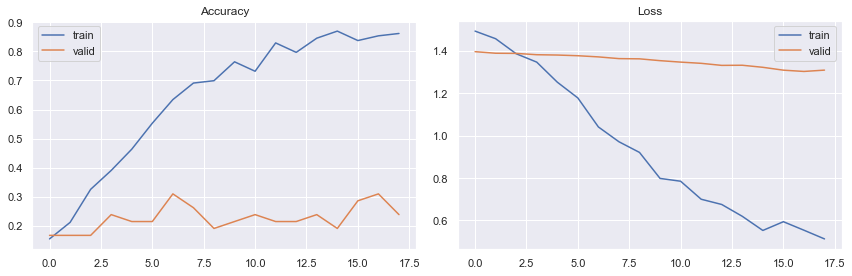

In [34]:
 modelTrained = compileAndTrain('DenseNet201', 'm2', DATASET, model, train_generator, valid_generator, 
                                X_train, class_weights) 

(42, 224, 224, 3) (42, 4)
2/2 [==============================] - 5s 936ms/step
total wrong validation predictions: 31


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.27      1.00      0.42        11
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10

    accuracy                           0.26        42
   macro avg       0.07      0.25      0.11        42
weighted avg       0.07      0.26      0.11        42



/home/s462321333/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/s462321333/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/s462321333/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


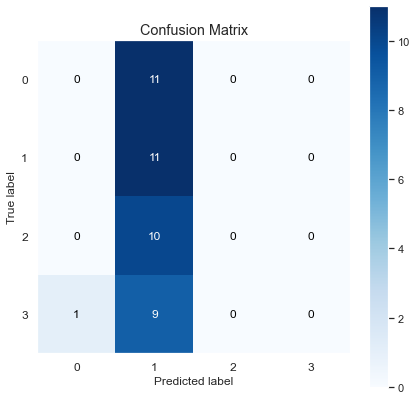

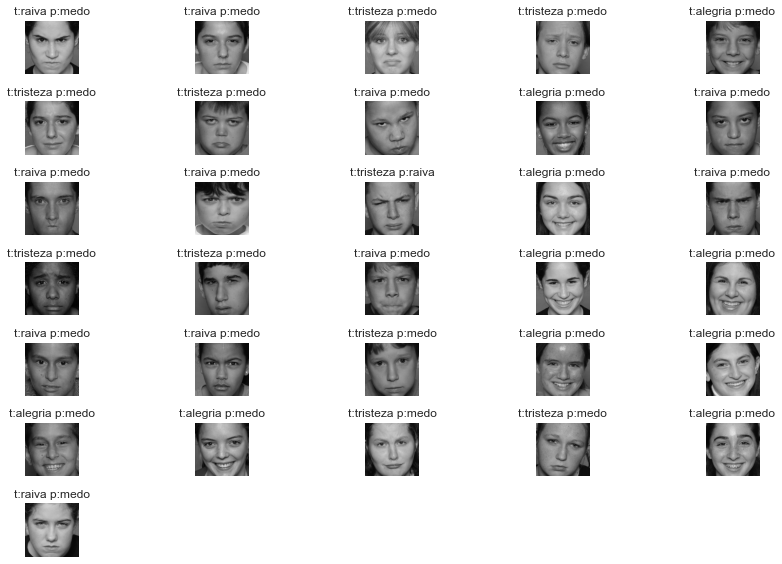

In [35]:
yhat = test_model('DenseNet201', 'm2', DATASET, modelTrained, X_test, y_test, emotions_labels)

### ResNet50V2 - M1

In [36]:
model = createModel('ResNet50V2', img_height, img_width, modelType='m1', num_classes=4)

Model: "model_6"
_____________________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  Trainable  
 input_7 (InputLayer)        [(None, 224, 224, 3)]        0         []                            N          
                                                                                                             
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_7[0][0]']             N          
                                                                                                             
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           N          
                                                                                                             
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          N    

 conv2_block2_2_relu (Activ  (None, 56, 56, 64)           0         ['conv2_block2_2_bn[0][0]']   N          
 ation)                                                                                                      
                                                                                                             
 conv2_block2_3_conv (Conv2  (None, 56, 56, 256)          16640     ['conv2_block2_2_relu[0][0]   N          
 D)                                                                 ']                                       
                                                                                                             
 conv2_block2_out (Add)      (None, 56, 56, 256)          0         ['conv2_block1_out[0][0]',    N          
                                                                     'conv2_block2_3_conv[0][0]              
                                                                    ']                                       
          

 D)                                                                 0][0]']                                  
                                                                                                             
 conv3_block1_3_conv (Conv2  (None, 28, 28, 512)          66048     ['conv3_block1_2_relu[0][0]   N          
 D)                                                                 ']                                       
                                                                                                             
 conv3_block1_out (Add)      (None, 28, 28, 512)          0         ['conv3_block1_0_conv[0][0]   N          
                                                                    ',                                       
                                                                     'conv3_block1_3_conv[0][0]              
                                                                    ']                                       
          

                                                                     'conv3_block3_3_conv[0][0]              
                                                                    ']                                       
                                                                                                             
 conv3_block4_preact_bn (Ba  (None, 28, 28, 512)          2048      ['conv3_block3_out[0][0]']    N          
 tchNormalization)                                                                                           
                                                                                                             
 conv3_block4_preact_relu (  (None, 28, 28, 512)          0         ['conv3_block4_preact_bn[0]   N          
 Activation)                                                        [0]']                                    
                                                                                                             
 conv3_blo

                                                                     'conv4_block1_3_conv[0][0]              
                                                                    ']                                       
                                                                                                             
 conv4_block2_preact_bn (Ba  (None, 14, 14, 1024)         4096      ['conv4_block1_out[0][0]']    N          
 tchNormalization)                                                                                           
                                                                                                             
 conv4_block2_preact_relu (  (None, 14, 14, 1024)         0         ['conv4_block2_preact_bn[0]   N          
 Activation)                                                        [0]']                                    
                                                                                                             
 conv4_blo

 Activation)                                                        [0]']                                    
                                                                                                             
 conv4_block4_1_conv (Conv2  (None, 14, 14, 256)          262144    ['conv4_block4_preact_relu[   N          
 D)                                                                 0][0]']                                  
                                                                                                             
 conv4_block4_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block4_1_conv[0][0]   N          
 rmalization)                                                       ']                                       
                                                                                                             
 conv4_block4_1_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block4_1_bn[0][0]']   N          
 ation)   

                                                                                                             
 conv4_block6_1_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block6_1_bn[0][0]']   N          
 ation)                                                                                                      
                                                                                                             
 conv4_block6_2_pad (ZeroPa  (None, 16, 16, 256)          0         ['conv4_block6_1_relu[0][0]   N          
 dding2D)                                                           ']                                       
                                                                                                             
 conv4_block6_2_conv (Conv2  (None, 7, 7, 256)            589824    ['conv4_block6_2_pad[0][0]'   N          
 D)                                                                 ]                                        
          

                                                                                                             
 conv5_block2_1_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block2_1_bn[0][0]']   N          
 ation)                                                                                                      
                                                                                                             
 conv5_block2_2_pad (ZeroPa  (None, 9, 9, 512)            0         ['conv5_block2_1_relu[0][0]   N          
 dding2D)                                                           ']                                       
                                                                                                             
 conv5_block2_2_conv (Conv2  (None, 7, 7, 512)            2359296   ['conv5_block2_2_pad[0][0]'   N          
 D)                                                                 ]                                        
          

Epoch 1/30
6/6 [==============================] - 15s 2s/step - loss: 5.3797 - accuracy: 0.2520 - val_loss: 1.5704 - val_accuracy: 0.3333 - lr: 1.0000e-04
Epoch 2/30
6/6 [==============================] - 12s 2s/step - loss: 2.3843 - accuracy: 0.3902 - val_loss: 1.8822 - val_accuracy: 0.3571 - lr: 1.0000e-04
Epoch 3/30
6/6 [==============================] - 12s 2s/step - loss: 2.0986 - accuracy: 0.3659 - val_loss: 1.4353 - val_accuracy: 0.4524 - lr: 1.0000e-04
Epoch 4/30
6/6 [==============================] - 12s 2s/step - loss: 1.7522 - accuracy: 0.4228 - val_loss: 1.1839 - val_accuracy: 0.4524 - lr: 1.0000e-04
Epoch 5/30
6/6 [==============================] - 12s 2s/step - loss: 1.4934 - accuracy: 0.4553 - val_loss: 1.0782 - val_accuracy: 0.5238 - lr: 1.0000e-04
Epoch 6/30
6/6 [==============================] - 12s 2s/step - loss: 1.1076 - accuracy: 0.5772 - val_loss: 0.8678 - val_accuracy: 0.5952 - lr: 1.0000e-04
Epoch 7/30
6/6 [==============================] - 12s 2s/step - loss: 

/home/s462321333/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


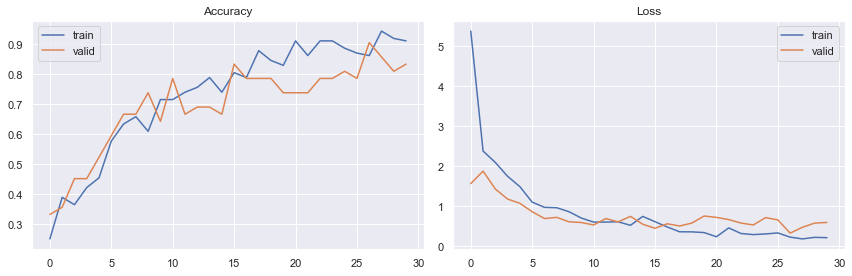

In [37]:
 modelTrained = compileAndTrain('ResNet50V2', 'm1', DATASET, model, train_generator, valid_generator, 
                                X_train, class_weights) 

(42, 224, 224, 3) (42, 4)
2/2 [==============================] - 3s 655ms/step
total wrong validation predictions: 8


              precision    recall  f1-score   support

           0       0.86      0.55      0.67        11
           1       0.79      1.00      0.88        11
           2       1.00      1.00      1.00        10
           3       0.64      0.70      0.67        10

    accuracy                           0.81        42
   macro avg       0.82      0.81      0.80        42
weighted avg       0.82      0.81      0.80        42



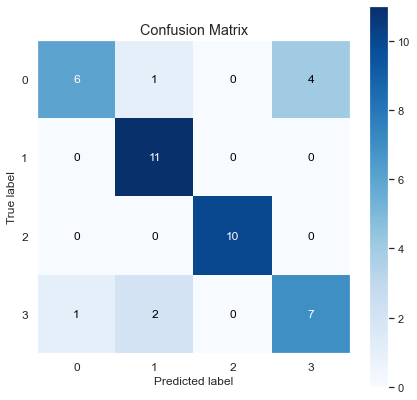

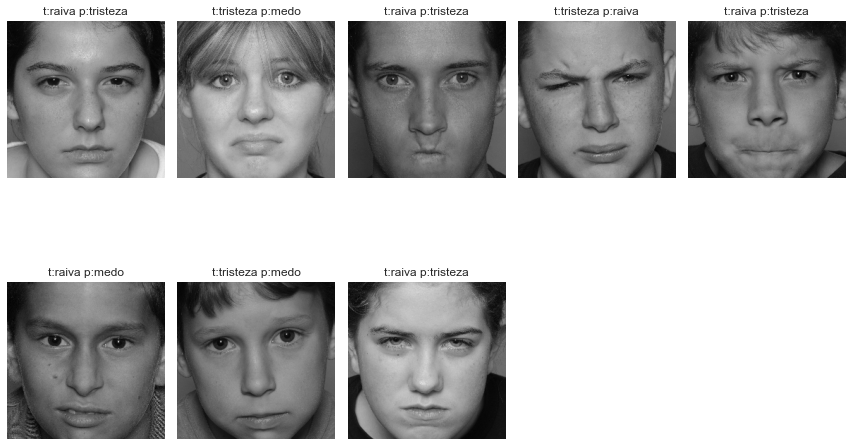

In [38]:
yhat = test_model('ResNet50V2', 'm1', DATASET, modelTrained, X_test, y_test, emotions_labels)

### ResNet50V2 - M2

In [39]:
model = createModel('ResNet50V2', img_height, img_width, modelType='m2', num_classes=4)

Model: "model_7"
_____________________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  Trainable  
 input_8 (InputLayer)        [(None, 224, 224, 3)]        0         []                            N          
                                                                                                             
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_8[0][0]']             N          
                                                                                                             
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           N          
                                                                                                             
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          N    

 conv2_block2_2_relu (Activ  (None, 56, 56, 64)           0         ['conv2_block2_2_bn[0][0]']   N          
 ation)                                                                                                      
                                                                                                             
 conv2_block2_3_conv (Conv2  (None, 56, 56, 256)          16640     ['conv2_block2_2_relu[0][0]   N          
 D)                                                                 ']                                       
                                                                                                             
 conv2_block2_out (Add)      (None, 56, 56, 256)          0         ['conv2_block1_out[0][0]',    N          
                                                                     'conv2_block2_3_conv[0][0]              
                                                                    ']                                       
          

 D)                                                                 0][0]']                                  
                                                                                                             
 conv3_block1_3_conv (Conv2  (None, 28, 28, 512)          66048     ['conv3_block1_2_relu[0][0]   N          
 D)                                                                 ']                                       
                                                                                                             
 conv3_block1_out (Add)      (None, 28, 28, 512)          0         ['conv3_block1_0_conv[0][0]   N          
                                                                    ',                                       
                                                                     'conv3_block1_3_conv[0][0]              
                                                                    ']                                       
          

                                                                     'conv3_block3_3_conv[0][0]              
                                                                    ']                                       
                                                                                                             
 conv3_block4_preact_bn (Ba  (None, 28, 28, 512)          2048      ['conv3_block3_out[0][0]']    N          
 tchNormalization)                                                                                           
                                                                                                             
 conv3_block4_preact_relu (  (None, 28, 28, 512)          0         ['conv3_block4_preact_bn[0]   N          
 Activation)                                                        [0]']                                    
                                                                                                             
 conv3_blo

                                                                     'conv4_block1_3_conv[0][0]              
                                                                    ']                                       
                                                                                                             
 conv4_block2_preact_bn (Ba  (None, 14, 14, 1024)         4096      ['conv4_block1_out[0][0]']    N          
 tchNormalization)                                                                                           
                                                                                                             
 conv4_block2_preact_relu (  (None, 14, 14, 1024)         0         ['conv4_block2_preact_bn[0]   N          
 Activation)                                                        [0]']                                    
                                                                                                             
 conv4_blo

 Activation)                                                        [0]']                                    
                                                                                                             
 conv4_block4_1_conv (Conv2  (None, 14, 14, 256)          262144    ['conv4_block4_preact_relu[   N          
 D)                                                                 0][0]']                                  
                                                                                                             
 conv4_block4_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block4_1_conv[0][0]   N          
 rmalization)                                                       ']                                       
                                                                                                             
 conv4_block4_1_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block4_1_bn[0][0]']   N          
 ation)   

                                                                                                             
 conv4_block6_1_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block6_1_bn[0][0]']   N          
 ation)                                                                                                      
                                                                                                             
 conv4_block6_2_pad (ZeroPa  (None, 16, 16, 256)          0         ['conv4_block6_1_relu[0][0]   N          
 dding2D)                                                           ']                                       
                                                                                                             
 conv4_block6_2_conv (Conv2  (None, 7, 7, 256)            589824    ['conv4_block6_2_pad[0][0]'   N          
 D)                                                                 ]                                        
          

                                                                                                             
 conv5_block2_1_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block2_1_bn[0][0]']   N          
 ation)                                                                                                      
                                                                                                             
 conv5_block2_2_pad (ZeroPa  (None, 9, 9, 512)            0         ['conv5_block2_1_relu[0][0]   N          
 dding2D)                                                           ']                                       
                                                                                                             
 conv5_block2_2_conv (Conv2  (None, 7, 7, 512)            2359296   ['conv5_block2_2_pad[0][0]'   N          
 D)                                                                 ]                                        
          

Epoch 1/30
6/6 [==============================] - 14s 2s/step - loss: 1.4821 - accuracy: 0.3984 - val_loss: 2.1445 - val_accuracy: 0.1667 - lr: 1.0000e-04
Epoch 2/30
6/6 [==============================] - 11s 2s/step - loss: 0.6999 - accuracy: 0.7236 - val_loss: 2.2184 - val_accuracy: 0.1667 - lr: 1.0000e-04
Epoch 3/30
6/6 [==============================] - 11s 2s/step - loss: 0.6293 - accuracy: 0.8130 - val_loss: 2.2613 - val_accuracy: 0.2143 - lr: 1.0000e-04
Epoch 4/30
6/6 [==============================] - 11s 2s/step - loss: 0.5344 - accuracy: 0.7967 - val_loss: 2.2789 - val_accuracy: 0.2857 - lr: 1.0000e-04
Epoch 5/30
6/6 [==============================] - 11s 2s/step - loss: 0.2546 - accuracy: 0.9024 - val_loss: 2.2644 - val_accuracy: 0.2381 - lr: 1.0000e-04
Epoch 6/30
6/6 [==============================] - 11s 2s/step - loss: 0.3724 - accuracy: 0.8537 - val_loss: 1.8496 - val_accuracy: 0.1905 - lr: 1.0000e-04
Epoch 7/30
6/6 [==============================] - 11s 2s/step - loss: 

/home/s462321333/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


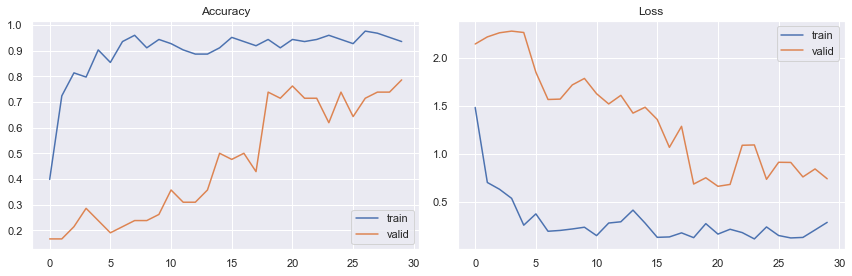

In [40]:
 modelTrained = compileAndTrain('ResNet50V2', 'm2', DATASET, model, train_generator, valid_generator, 
                                X_train, class_weights) 

(42, 224, 224, 3) (42, 4)
2/2 [==============================] - 3s 634ms/step
total wrong validation predictions: 13


              precision    recall  f1-score   support

           0       0.67      0.18      0.29        11
           1       0.91      0.91      0.91        11
           2       1.00      0.90      0.95        10
           3       0.42      0.80      0.55        10

    accuracy                           0.69        42
   macro avg       0.75      0.70      0.67        42
weighted avg       0.75      0.69      0.67        42



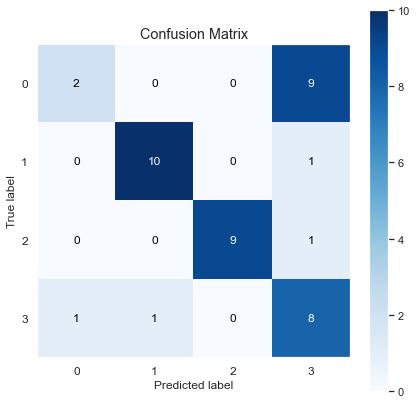

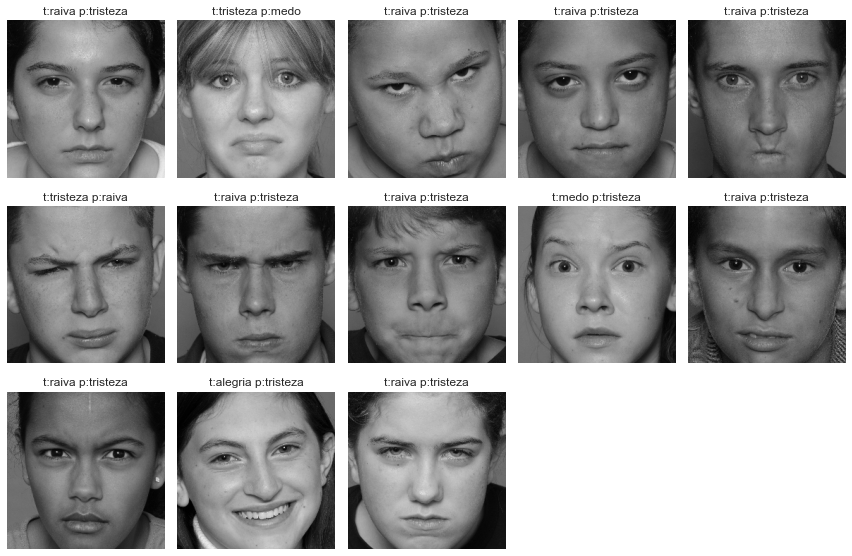

In [41]:
yhat = test_model('ResNet50V2', 'm2', DATASET, modelTrained, X_test, y_test, emotions_labels)

### ResNet101V2 - M1

In [42]:
model = createModel('ResNet101V2', img_height, img_width, modelType='m1', num_classes=4)

Model: "model_8"
_____________________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  Trainable  
 input_9 (InputLayer)        [(None, 224, 224, 3)]        0         []                            N          
                                                                                                             
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_9[0][0]']             N          
                                                                                                             
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           N          
                                                                                                             
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          N    

 conv2_block2_2_relu (Activ  (None, 56, 56, 64)           0         ['conv2_block2_2_bn[0][0]']   N          
 ation)                                                                                                      
                                                                                                             
 conv2_block2_3_conv (Conv2  (None, 56, 56, 256)          16640     ['conv2_block2_2_relu[0][0]   N          
 D)                                                                 ']                                       
                                                                                                             
 conv2_block2_out (Add)      (None, 56, 56, 256)          0         ['conv2_block1_out[0][0]',    N          
                                                                     'conv2_block2_3_conv[0][0]              
                                                                    ']                                       
          

 D)                                                                 0][0]']                                  
                                                                                                             
 conv3_block1_3_conv (Conv2  (None, 28, 28, 512)          66048     ['conv3_block1_2_relu[0][0]   N          
 D)                                                                 ']                                       
                                                                                                             
 conv3_block1_out (Add)      (None, 28, 28, 512)          0         ['conv3_block1_0_conv[0][0]   N          
                                                                    ',                                       
                                                                     'conv3_block1_3_conv[0][0]              
                                                                    ']                                       
          

                                                                     'conv3_block3_3_conv[0][0]              
                                                                    ']                                       
                                                                                                             
 conv3_block4_preact_bn (Ba  (None, 28, 28, 512)          2048      ['conv3_block3_out[0][0]']    N          
 tchNormalization)                                                                                           
                                                                                                             
 conv3_block4_preact_relu (  (None, 28, 28, 512)          0         ['conv3_block4_preact_bn[0]   N          
 Activation)                                                        [0]']                                    
                                                                                                             
 conv3_blo

                                                                     'conv4_block1_3_conv[0][0]              
                                                                    ']                                       
                                                                                                             
 conv4_block2_preact_bn (Ba  (None, 14, 14, 1024)         4096      ['conv4_block1_out[0][0]']    N          
 tchNormalization)                                                                                           
                                                                                                             
 conv4_block2_preact_relu (  (None, 14, 14, 1024)         0         ['conv4_block2_preact_bn[0]   N          
 Activation)                                                        [0]']                                    
                                                                                                             
 conv4_blo

 Activation)                                                        [0]']                                    
                                                                                                             
 conv4_block4_1_conv (Conv2  (None, 14, 14, 256)          262144    ['conv4_block4_preact_relu[   N          
 D)                                                                 0][0]']                                  
                                                                                                             
 conv4_block4_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block4_1_conv[0][0]   N          
 rmalization)                                                       ']                                       
                                                                                                             
 conv4_block4_1_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block4_1_bn[0][0]']   N          
 ation)   

                                                                                                             
 conv4_block6_1_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block6_1_bn[0][0]']   N          
 ation)                                                                                                      
                                                                                                             
 conv4_block6_2_pad (ZeroPa  (None, 16, 16, 256)          0         ['conv4_block6_1_relu[0][0]   N          
 dding2D)                                                           ']                                       
                                                                                                             
 conv4_block6_2_conv (Conv2  (None, 14, 14, 256)          589824    ['conv4_block6_2_pad[0][0]'   N          
 D)                                                                 ]                                        
          

 conv4_block8_2_conv (Conv2  (None, 14, 14, 256)          589824    ['conv4_block8_2_pad[0][0]'   N          
 D)                                                                 ]                                        
                                                                                                             
 conv4_block8_2_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block8_2_conv[0][0]   N          
 rmalization)                                                       ']                                       
                                                                                                             
 conv4_block8_2_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block8_2_bn[0][0]']   N          
 ation)                                                                                                      
                                                                                                             
 conv4_blo

 vation)                                                            ]                                        
                                                                                                             
 conv4_block10_3_conv (Conv  (None, 14, 14, 1024)         263168    ['conv4_block10_2_relu[0][0   N          
 2D)                                                                ]']                                      
                                                                                                             
 conv4_block10_out (Add)     (None, 14, 14, 1024)         0         ['conv4_block9_out[0][0]',    N          
                                                                     'conv4_block10_3_conv[0][0              
                                                                    ]']                                      
                                                                                                             
 conv4_blo

                                                                    ]']                                      
                                                                                                             
 conv4_block13_preact_bn (B  (None, 14, 14, 1024)         4096      ['conv4_block12_out[0][0]']   N          
 atchNormalization)                                                                                          
                                                                                                             
 conv4_block13_preact_relu   (None, 14, 14, 1024)         0         ['conv4_block13_preact_bn[0   N          
 (Activation)                                                       ][0]']                                   
                                                                                                             
 conv4_block13_1_conv (Conv  (None, 14, 14, 256)          262144    ['conv4_block13_preact_relu   N          
 2D)      

                                                                                                             
 conv4_block15_1_conv (Conv  (None, 14, 14, 256)          262144    ['conv4_block15_preact_relu   N          
 2D)                                                                [0][0]']                                 
                                                                                                             
 conv4_block15_1_bn (BatchN  (None, 14, 14, 256)          1024      ['conv4_block15_1_conv[0][0   N          
 ormalization)                                                      ]']                                      
                                                                                                             
 conv4_block15_1_relu (Acti  (None, 14, 14, 256)          0         ['conv4_block15_1_bn[0][0]'   N          
 vation)                                                            ]                                        
          

 conv4_block17_1_relu (Acti  (None, 14, 14, 256)          0         ['conv4_block17_1_bn[0][0]'   N          
 vation)                                                            ]                                        
                                                                                                             
 conv4_block17_2_pad (ZeroP  (None, 16, 16, 256)          0         ['conv4_block17_1_relu[0][0   N          
 adding2D)                                                          ]']                                      
                                                                                                             
 conv4_block17_2_conv (Conv  (None, 14, 14, 256)          589824    ['conv4_block17_2_pad[0][0]   N          
 2D)                                                                ']                                       
                                                                                                             
 conv4_blo

 2D)                                                                ']                                       
                                                                                                             
 conv4_block19_2_bn (BatchN  (None, 14, 14, 256)          1024      ['conv4_block19_2_conv[0][0   N          
 ormalization)                                                      ]']                                      
                                                                                                             
 conv4_block19_2_relu (Acti  (None, 14, 14, 256)          0         ['conv4_block19_2_bn[0][0]'   N          
 vation)                                                            ]                                        
                                                                                                             
 conv4_block19_3_conv (Conv  (None, 14, 14, 1024)         263168    ['conv4_block19_2_relu[0][0   N          
 2D)      

                                                                                                             
 conv4_block21_3_conv (Conv  (None, 14, 14, 1024)         263168    ['conv4_block21_2_relu[0][0   N          
 2D)                                                                ]']                                      
                                                                                                             
 conv4_block21_out (Add)     (None, 14, 14, 1024)         0         ['conv4_block20_out[0][0]',   N          
                                                                     'conv4_block21_3_conv[0][0              
                                                                    ]']                                      
                                                                                                             
 conv4_block22_preact_bn (B  (None, 14, 14, 1024)         4096      ['conv4_block21_out[0][0]']   N          
 atchNorma

 conv4_block23_out (Add)     (None, 7, 7, 1024)           0         ['max_pooling2d_8[0][0]',     N          
                                                                     'conv4_block23_3_conv[0][0              
                                                                    ]']                                      
                                                                                                             
 conv5_block1_preact_bn (Ba  (None, 7, 7, 1024)           4096      ['conv4_block23_out[0][0]']   N          
 tchNormalization)                                                                                           
                                                                                                             
 conv5_block1_preact_relu (  (None, 7, 7, 1024)           0         ['conv5_block1_preact_bn[0]   N          
 Activation)                                                        [0]']                                    
          

                                                                                                             
 conv5_block3_preact_bn (Ba  (None, 7, 7, 2048)           8192      ['conv5_block2_out[0][0]']    N          
 tchNormalization)                                                                                           
                                                                                                             
 conv5_block3_preact_relu (  (None, 7, 7, 2048)           0         ['conv5_block3_preact_bn[0]   Y          
 Activation)                                                        [0]']                                    
                                                                                                             
 conv5_block3_1_conv (Conv2  (None, 7, 7, 512)            1048576   ['conv5_block3_preact_relu[   Y          
 D)                                                                 0][0]']                                  
          

Epoch 1/30
6/6 [==============================] - 27s 4s/step - loss: 8.1406 - accuracy: 0.2683 - val_loss: 4.0169 - val_accuracy: 0.2619 - lr: 1.0000e-04
Epoch 2/30
6/6 [==============================] - 22s 4s/step - loss: 3.0737 - accuracy: 0.3659 - val_loss: 1.5310 - val_accuracy: 0.4524 - lr: 1.0000e-04
Epoch 3/30
6/6 [==============================] - 22s 4s/step - loss: 2.6669 - accuracy: 0.3577 - val_loss: 1.9908 - val_accuracy: 0.3810 - lr: 1.0000e-04
Epoch 4/30
6/6 [==============================] - 23s 4s/step - loss: 1.7615 - accuracy: 0.4553 - val_loss: 1.0800 - val_accuracy: 0.5476 - lr: 1.0000e-04
Epoch 5/30
6/6 [==============================] - 23s 4s/step - loss: 1.3393 - accuracy: 0.4472 - val_loss: 0.9247 - val_accuracy: 0.5952 - lr: 1.0000e-04
Epoch 6/30
6/6 [==============================] - 22s 4s/step - loss: 1.0351 - accuracy: 0.5935 - val_loss: 0.7404 - val_accuracy: 0.6429 - lr: 1.0000e-04
Epoch 7/30
6/6 [==============================] - 22s 4s/step - loss: 

/home/s462321333/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


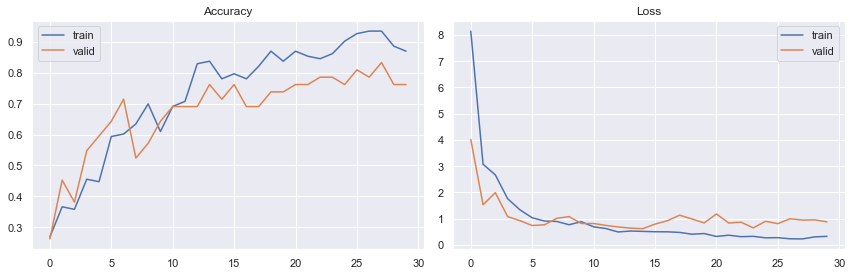

In [43]:
 modelTrained = compileAndTrain('ResNet101V2', 'm1', DATASET, model, train_generator, valid_generator, 
                                X_train, class_weights) 

(42, 224, 224, 3) (42, 4)
2/2 [==============================] - 6s 1s/step
total wrong validation predictions: 10


              precision    recall  f1-score   support

           0       0.80      0.36      0.50        11
           1       0.85      1.00      0.92        11
           2       1.00      1.00      1.00        10
           3       0.50      0.70      0.58        10

    accuracy                           0.76        42
   macro avg       0.79      0.77      0.75        42
weighted avg       0.79      0.76      0.75        42



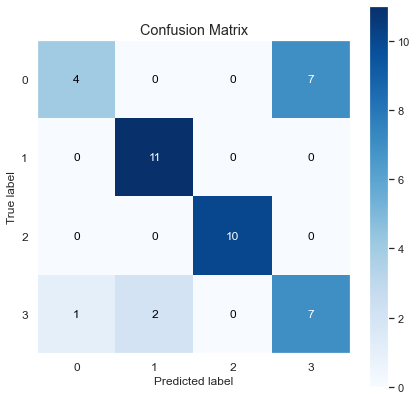

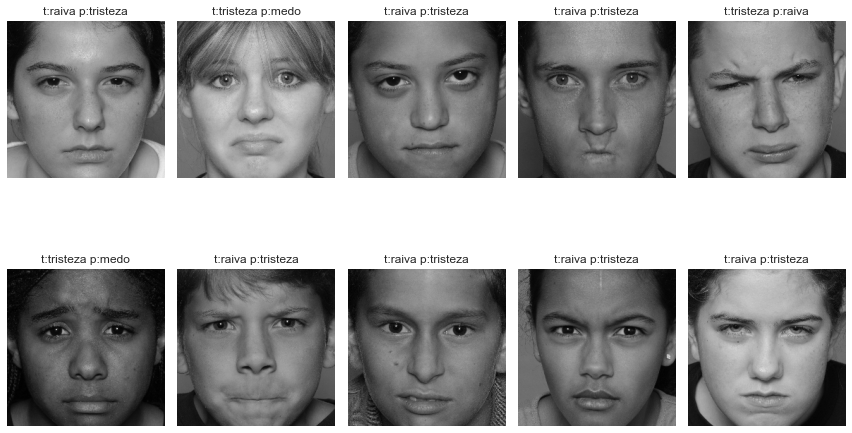

In [44]:
yhat = test_model('ResNet101V2', 'm1', DATASET, modelTrained, X_test, y_test, emotions_labels)

### ResNet101V2 - M2

In [45]:
model = createModel('ResNet101V2', img_height, img_width, modelType='m2', num_classes=4)

Model: "model_9"
_____________________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  Trainable  
 input_10 (InputLayer)       [(None, 224, 224, 3)]        0         []                            N          
                                                                                                             
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_10[0][0]']            N          
                                                                                                             
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           N          
                                                                                                             
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          N    

 conv2_block2_2_relu (Activ  (None, 56, 56, 64)           0         ['conv2_block2_2_bn[0][0]']   N          
 ation)                                                                                                      
                                                                                                             
 conv2_block2_3_conv (Conv2  (None, 56, 56, 256)          16640     ['conv2_block2_2_relu[0][0]   N          
 D)                                                                 ']                                       
                                                                                                             
 conv2_block2_out (Add)      (None, 56, 56, 256)          0         ['conv2_block1_out[0][0]',    N          
                                                                     'conv2_block2_3_conv[0][0]              
                                                                    ']                                       
          

 D)                                                                 0][0]']                                  
                                                                                                             
 conv3_block1_3_conv (Conv2  (None, 28, 28, 512)          66048     ['conv3_block1_2_relu[0][0]   N          
 D)                                                                 ']                                       
                                                                                                             
 conv3_block1_out (Add)      (None, 28, 28, 512)          0         ['conv3_block1_0_conv[0][0]   N          
                                                                    ',                                       
                                                                     'conv3_block1_3_conv[0][0]              
                                                                    ']                                       
          

                                                                     'conv3_block3_3_conv[0][0]              
                                                                    ']                                       
                                                                                                             
 conv3_block4_preact_bn (Ba  (None, 28, 28, 512)          2048      ['conv3_block3_out[0][0]']    N          
 tchNormalization)                                                                                           
                                                                                                             
 conv3_block4_preact_relu (  (None, 28, 28, 512)          0         ['conv3_block4_preact_bn[0]   N          
 Activation)                                                        [0]']                                    
                                                                                                             
 conv3_blo

                                                                     'conv4_block1_3_conv[0][0]              
                                                                    ']                                       
                                                                                                             
 conv4_block2_preact_bn (Ba  (None, 14, 14, 1024)         4096      ['conv4_block1_out[0][0]']    N          
 tchNormalization)                                                                                           
                                                                                                             
 conv4_block2_preact_relu (  (None, 14, 14, 1024)         0         ['conv4_block2_preact_bn[0]   N          
 Activation)                                                        [0]']                                    
                                                                                                             
 conv4_blo

 Activation)                                                        [0]']                                    
                                                                                                             
 conv4_block4_1_conv (Conv2  (None, 14, 14, 256)          262144    ['conv4_block4_preact_relu[   N          
 D)                                                                 0][0]']                                  
                                                                                                             
 conv4_block4_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block4_1_conv[0][0]   N          
 rmalization)                                                       ']                                       
                                                                                                             
 conv4_block4_1_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block4_1_bn[0][0]']   N          
 ation)   

                                                                                                             
 conv4_block6_1_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block6_1_bn[0][0]']   N          
 ation)                                                                                                      
                                                                                                             
 conv4_block6_2_pad (ZeroPa  (None, 16, 16, 256)          0         ['conv4_block6_1_relu[0][0]   N          
 dding2D)                                                           ']                                       
                                                                                                             
 conv4_block6_2_conv (Conv2  (None, 14, 14, 256)          589824    ['conv4_block6_2_pad[0][0]'   N          
 D)                                                                 ]                                        
          

 conv4_block8_2_conv (Conv2  (None, 14, 14, 256)          589824    ['conv4_block8_2_pad[0][0]'   N          
 D)                                                                 ]                                        
                                                                                                             
 conv4_block8_2_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block8_2_conv[0][0]   N          
 rmalization)                                                       ']                                       
                                                                                                             
 conv4_block8_2_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block8_2_bn[0][0]']   N          
 ation)                                                                                                      
                                                                                                             
 conv4_blo

 vation)                                                            ]                                        
                                                                                                             
 conv4_block10_3_conv (Conv  (None, 14, 14, 1024)         263168    ['conv4_block10_2_relu[0][0   N          
 2D)                                                                ]']                                      
                                                                                                             
 conv4_block10_out (Add)     (None, 14, 14, 1024)         0         ['conv4_block9_out[0][0]',    N          
                                                                     'conv4_block10_3_conv[0][0              
                                                                    ]']                                      
                                                                                                             
 conv4_blo

                                                                    ]']                                      
                                                                                                             
 conv4_block13_preact_bn (B  (None, 14, 14, 1024)         4096      ['conv4_block12_out[0][0]']   N          
 atchNormalization)                                                                                          
                                                                                                             
 conv4_block13_preact_relu   (None, 14, 14, 1024)         0         ['conv4_block13_preact_bn[0   N          
 (Activation)                                                       ][0]']                                   
                                                                                                             
 conv4_block13_1_conv (Conv  (None, 14, 14, 256)          262144    ['conv4_block13_preact_relu   N          
 2D)      

                                                                                                             
 conv4_block15_1_conv (Conv  (None, 14, 14, 256)          262144    ['conv4_block15_preact_relu   N          
 2D)                                                                [0][0]']                                 
                                                                                                             
 conv4_block15_1_bn (BatchN  (None, 14, 14, 256)          1024      ['conv4_block15_1_conv[0][0   N          
 ormalization)                                                      ]']                                      
                                                                                                             
 conv4_block15_1_relu (Acti  (None, 14, 14, 256)          0         ['conv4_block15_1_bn[0][0]'   N          
 vation)                                                            ]                                        
          

 conv4_block17_1_relu (Acti  (None, 14, 14, 256)          0         ['conv4_block17_1_bn[0][0]'   N          
 vation)                                                            ]                                        
                                                                                                             
 conv4_block17_2_pad (ZeroP  (None, 16, 16, 256)          0         ['conv4_block17_1_relu[0][0   N          
 adding2D)                                                          ]']                                      
                                                                                                             
 conv4_block17_2_conv (Conv  (None, 14, 14, 256)          589824    ['conv4_block17_2_pad[0][0]   N          
 2D)                                                                ']                                       
                                                                                                             
 conv4_blo

 2D)                                                                ']                                       
                                                                                                             
 conv4_block19_2_bn (BatchN  (None, 14, 14, 256)          1024      ['conv4_block19_2_conv[0][0   N          
 ormalization)                                                      ]']                                      
                                                                                                             
 conv4_block19_2_relu (Acti  (None, 14, 14, 256)          0         ['conv4_block19_2_bn[0][0]'   N          
 vation)                                                            ]                                        
                                                                                                             
 conv4_block19_3_conv (Conv  (None, 14, 14, 1024)         263168    ['conv4_block19_2_relu[0][0   N          
 2D)      

                                                                                                             
 conv4_block21_3_conv (Conv  (None, 14, 14, 1024)         263168    ['conv4_block21_2_relu[0][0   N          
 2D)                                                                ]']                                      
                                                                                                             
 conv4_block21_out (Add)     (None, 14, 14, 1024)         0         ['conv4_block20_out[0][0]',   N          
                                                                     'conv4_block21_3_conv[0][0              
                                                                    ]']                                      
                                                                                                             
 conv4_block22_preact_bn (B  (None, 14, 14, 1024)         4096      ['conv4_block21_out[0][0]']   N          
 atchNorma

 conv4_block23_out (Add)     (None, 7, 7, 1024)           0         ['max_pooling2d_11[0][0]',    N          
                                                                     'conv4_block23_3_conv[0][0              
                                                                    ]']                                      
                                                                                                             
 conv5_block1_preact_bn (Ba  (None, 7, 7, 1024)           4096      ['conv4_block23_out[0][0]']   N          
 tchNormalization)                                                                                           
                                                                                                             
 conv5_block1_preact_relu (  (None, 7, 7, 1024)           0         ['conv5_block1_preact_bn[0]   N          
 Activation)                                                        [0]']                                    
          

                                                                                                             
 conv5_block3_preact_bn (Ba  (None, 7, 7, 2048)           8192      ['conv5_block2_out[0][0]']    N          
 tchNormalization)                                                                                           
                                                                                                             
 conv5_block3_preact_relu (  (None, 7, 7, 2048)           0         ['conv5_block3_preact_bn[0]   Y          
 Activation)                                                        [0]']                                    
                                                                                                             
 conv5_block3_1_conv (Conv2  (None, 7, 7, 512)            1048576   ['conv5_block3_preact_relu[   Y          
 D)                                                                 0][0]']                                  
          

Epoch 1/30
6/6 [==============================] - 26s 4s/step - loss: 1.2899 - accuracy: 0.5122 - val_loss: 1.6079 - val_accuracy: 0.2857 - lr: 1.0000e-04
Epoch 2/30
6/6 [==============================] - 22s 4s/step - loss: 0.7653 - accuracy: 0.7561 - val_loss: 1.4308 - val_accuracy: 0.3095 - lr: 1.0000e-04
Epoch 3/30
6/6 [==============================] - 22s 4s/step - loss: 0.6262 - accuracy: 0.7642 - val_loss: 1.4186 - val_accuracy: 0.3095 - lr: 1.0000e-04
Epoch 4/30
6/6 [==============================] - 22s 4s/step - loss: 0.4894 - accuracy: 0.8618 - val_loss: 1.4530 - val_accuracy: 0.3333 - lr: 1.0000e-04
Epoch 5/30
6/6 [==============================] - 22s 4s/step - loss: 0.3624 - accuracy: 0.8293 - val_loss: 1.5460 - val_accuracy: 0.3333 - lr: 1.0000e-04
Epoch 6/30
6/6 [==============================] - 22s 4s/step - loss: 0.3141 - accuracy: 0.8862 - val_loss: 1.4511 - val_accuracy: 0.3571 - lr: 1.0000e-04
Epoch 7/30
6/6 [==============================] - 22s 4s/step - loss: 

/home/s462321333/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


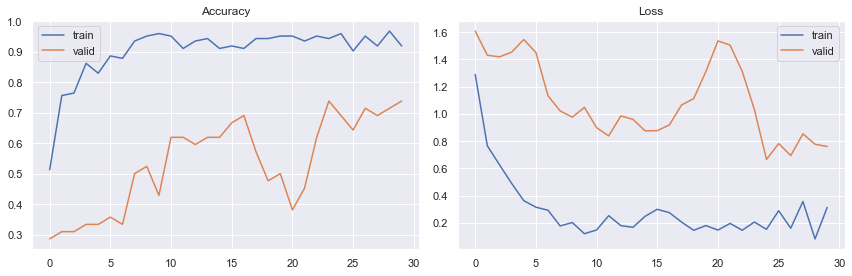

In [46]:
 modelTrained = compileAndTrain('ResNet101V2', 'm2', DATASET, model, train_generator, valid_generator, 
                                X_train, class_weights) 

(42, 224, 224, 3) (42, 4)
2/2 [==============================] - 6s 1s/step
total wrong validation predictions: 11


              precision    recall  f1-score   support

           0       0.78      0.64      0.70        11
           1       0.65      1.00      0.79        11
           2       1.00      1.00      1.00        10
           3       0.50      0.30      0.37        10

    accuracy                           0.74        42
   macro avg       0.73      0.73      0.72        42
weighted avg       0.73      0.74      0.72        42



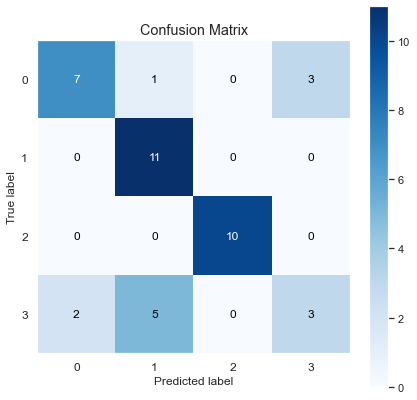

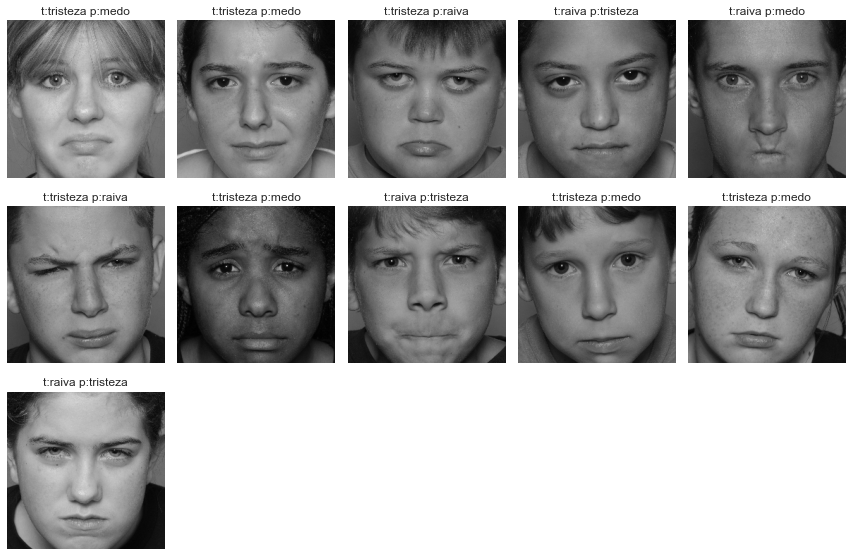

In [47]:
yhat = test_model('ResNet101V2', 'm2', DATASET, modelTrained, X_test, y_test, emotions_labels)

### ResNet152V2 - M1

In [48]:
model = createModel('ResNet152V2', img_height, img_width, modelType='m1', num_classes=4)

Model: "model_10"
_____________________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  Trainable  
 input_11 (InputLayer)       [(None, 224, 224, 3)]        0         []                            N          
                                                                                                             
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_11[0][0]']            N          
                                                                                                             
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           N          
                                                                                                             
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          N   

 conv2_block2_2_relu (Activ  (None, 56, 56, 64)           0         ['conv2_block2_2_bn[0][0]']   N          
 ation)                                                                                                      
                                                                                                             
 conv2_block2_3_conv (Conv2  (None, 56, 56, 256)          16640     ['conv2_block2_2_relu[0][0]   N          
 D)                                                                 ']                                       
                                                                                                             
 conv2_block2_out (Add)      (None, 56, 56, 256)          0         ['conv2_block1_out[0][0]',    N          
                                                                     'conv2_block2_3_conv[0][0]              
                                                                    ']                                       
          

 D)                                                                 0][0]']                                  
                                                                                                             
 conv3_block1_3_conv (Conv2  (None, 28, 28, 512)          66048     ['conv3_block1_2_relu[0][0]   N          
 D)                                                                 ']                                       
                                                                                                             
 conv3_block1_out (Add)      (None, 28, 28, 512)          0         ['conv3_block1_0_conv[0][0]   N          
                                                                    ',                                       
                                                                     'conv3_block1_3_conv[0][0]              
                                                                    ']                                       
          

                                                                     'conv3_block3_3_conv[0][0]              
                                                                    ']                                       
                                                                                                             
 conv3_block4_preact_bn (Ba  (None, 28, 28, 512)          2048      ['conv3_block3_out[0][0]']    N          
 tchNormalization)                                                                                           
                                                                                                             
 conv3_block4_preact_relu (  (None, 28, 28, 512)          0         ['conv3_block4_preact_bn[0]   N          
 Activation)                                                        [0]']                                    
                                                                                                             
 conv3_blo

 Activation)                                                        [0]']                                    
                                                                                                             
 conv3_block6_1_conv (Conv2  (None, 28, 28, 128)          65536     ['conv3_block6_preact_relu[   N          
 D)                                                                 0][0]']                                  
                                                                                                             
 conv3_block6_1_bn (BatchNo  (None, 28, 28, 128)          512       ['conv3_block6_1_conv[0][0]   N          
 rmalization)                                                       ']                                       
                                                                                                             
 conv3_block6_1_relu (Activ  (None, 28, 28, 128)          0         ['conv3_block6_1_bn[0][0]']   N          
 ation)   

                                                                                                             
 conv3_block8_1_relu (Activ  (None, 28, 28, 128)          0         ['conv3_block8_1_bn[0][0]']   N          
 ation)                                                                                                      
                                                                                                             
 conv3_block8_2_pad (ZeroPa  (None, 30, 30, 128)          0         ['conv3_block8_1_relu[0][0]   N          
 dding2D)                                                           ']                                       
                                                                                                             
 conv3_block8_2_conv (Conv2  (None, 14, 14, 128)          147456    ['conv3_block8_2_pad[0][0]'   N          
 D)                                                                 ]                                        
          

                                                                                                             
 conv4_block2_1_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block2_1_bn[0][0]']   N          
 ation)                                                                                                      
                                                                                                             
 conv4_block2_2_pad (ZeroPa  (None, 16, 16, 256)          0         ['conv4_block2_1_relu[0][0]   N          
 dding2D)                                                           ']                                       
                                                                                                             
 conv4_block2_2_conv (Conv2  (None, 14, 14, 256)          589824    ['conv4_block2_2_pad[0][0]'   N          
 D)                                                                 ]                                        
          

 conv4_block4_2_conv (Conv2  (None, 14, 14, 256)          589824    ['conv4_block4_2_pad[0][0]'   N          
 D)                                                                 ]                                        
                                                                                                             
 conv4_block4_2_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block4_2_conv[0][0]   N          
 rmalization)                                                       ']                                       
                                                                                                             
 conv4_block4_2_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block4_2_bn[0][0]']   N          
 ation)                                                                                                      
                                                                                                             
 conv4_blo

 ation)                                                                                                      
                                                                                                             
 conv4_block6_3_conv (Conv2  (None, 14, 14, 1024)         263168    ['conv4_block6_2_relu[0][0]   N          
 D)                                                                 ']                                       
                                                                                                             
 conv4_block6_out (Add)      (None, 14, 14, 1024)         0         ['conv4_block5_out[0][0]',    N          
                                                                     'conv4_block6_3_conv[0][0]              
                                                                    ']                                       
                                                                                                             
 conv4_blo

                                                                    ']                                       
                                                                                                             
 conv4_block9_preact_bn (Ba  (None, 14, 14, 1024)         4096      ['conv4_block8_out[0][0]']    N          
 tchNormalization)                                                                                           
                                                                                                             
 conv4_block9_preact_relu (  (None, 14, 14, 1024)         0         ['conv4_block9_preact_bn[0]   N          
 Activation)                                                        [0]']                                    
                                                                                                             
 conv4_block9_1_conv (Conv2  (None, 14, 14, 256)          262144    ['conv4_block9_preact_relu[   N          
 D)       

                                                                                                             
 conv4_block11_1_conv (Conv  (None, 14, 14, 256)          262144    ['conv4_block11_preact_relu   N          
 2D)                                                                [0][0]']                                 
                                                                                                             
 conv4_block11_1_bn (BatchN  (None, 14, 14, 256)          1024      ['conv4_block11_1_conv[0][0   N          
 ormalization)                                                      ]']                                      
                                                                                                             
 conv4_block11_1_relu (Acti  (None, 14, 14, 256)          0         ['conv4_block11_1_bn[0][0]'   N          
 vation)                                                            ]                                        
          

 conv4_block13_1_relu (Acti  (None, 14, 14, 256)          0         ['conv4_block13_1_bn[0][0]'   N          
 vation)                                                            ]                                        
                                                                                                             
 conv4_block13_2_pad (ZeroP  (None, 16, 16, 256)          0         ['conv4_block13_1_relu[0][0   N          
 adding2D)                                                          ]']                                      
                                                                                                             
 conv4_block13_2_conv (Conv  (None, 14, 14, 256)          589824    ['conv4_block13_2_pad[0][0]   N          
 2D)                                                                ']                                       
                                                                                                             
 conv4_blo

 2D)                                                                ']                                       
                                                                                                             
 conv4_block15_2_bn (BatchN  (None, 14, 14, 256)          1024      ['conv4_block15_2_conv[0][0   N          
 ormalization)                                                      ]']                                      
                                                                                                             
 conv4_block15_2_relu (Acti  (None, 14, 14, 256)          0         ['conv4_block15_2_bn[0][0]'   N          
 vation)                                                            ]                                        
                                                                                                             
 conv4_block15_3_conv (Conv  (None, 14, 14, 1024)         263168    ['conv4_block15_2_relu[0][0   N          
 2D)      

                                                                                                             
 conv4_block17_3_conv (Conv  (None, 14, 14, 1024)         263168    ['conv4_block17_2_relu[0][0   N          
 2D)                                                                ]']                                      
                                                                                                             
 conv4_block17_out (Add)     (None, 14, 14, 1024)         0         ['conv4_block16_out[0][0]',   N          
                                                                     'conv4_block17_3_conv[0][0              
                                                                    ]']                                      
                                                                                                             
 conv4_block18_preact_bn (B  (None, 14, 14, 1024)         4096      ['conv4_block17_out[0][0]']   N          
 atchNorma

                                                                                                             
 conv4_block20_preact_bn (B  (None, 14, 14, 1024)         4096      ['conv4_block19_out[0][0]']   N          
 atchNormalization)                                                                                          
                                                                                                             
 conv4_block20_preact_relu   (None, 14, 14, 1024)         0         ['conv4_block20_preact_bn[0   N          
 (Activation)                                                       ][0]']                                   
                                                                                                             
 conv4_block20_1_conv (Conv  (None, 14, 14, 256)          262144    ['conv4_block20_preact_relu   N          
 2D)                                                                [0][0]']                                 
          

 conv4_block22_1_conv (Conv  (None, 14, 14, 256)          262144    ['conv4_block22_preact_relu   N          
 2D)                                                                [0][0]']                                 
                                                                                                             
 conv4_block22_1_bn (BatchN  (None, 14, 14, 256)          1024      ['conv4_block22_1_conv[0][0   N          
 ormalization)                                                      ]']                                      
                                                                                                             
 conv4_block22_1_relu (Acti  (None, 14, 14, 256)          0         ['conv4_block22_1_bn[0][0]'   N          
 vation)                                                            ]                                        
                                                                                                             
 conv4_blo

 vation)                                                            ]                                        
                                                                                                             
 conv4_block24_2_pad (ZeroP  (None, 16, 16, 256)          0         ['conv4_block24_1_relu[0][0   N          
 adding2D)                                                          ]']                                      
                                                                                                             
 conv4_block24_2_conv (Conv  (None, 14, 14, 256)          589824    ['conv4_block24_2_pad[0][0]   N          
 2D)                                                                ']                                       
                                                                                                             
 conv4_block24_2_bn (BatchN  (None, 14, 14, 256)          1024      ['conv4_block24_2_conv[0][0   N          
 ormalizat

                                                                                                             
 conv4_block26_2_bn (BatchN  (None, 14, 14, 256)          1024      ['conv4_block26_2_conv[0][0   N          
 ormalization)                                                      ]']                                      
                                                                                                             
 conv4_block26_2_relu (Acti  (None, 14, 14, 256)          0         ['conv4_block26_2_bn[0][0]'   N          
 vation)                                                            ]                                        
                                                                                                             
 conv4_block26_3_conv (Conv  (None, 14, 14, 1024)         263168    ['conv4_block26_2_relu[0][0   N          
 2D)                                                                ]']                                      
          

 conv4_block28_3_conv (Conv  (None, 14, 14, 1024)         263168    ['conv4_block28_2_relu[0][0   N          
 2D)                                                                ]']                                      
                                                                                                             
 conv4_block28_out (Add)     (None, 14, 14, 1024)         0         ['conv4_block27_out[0][0]',   N          
                                                                     'conv4_block28_3_conv[0][0              
                                                                    ]']                                      
                                                                                                             
 conv4_block29_preact_bn (B  (None, 14, 14, 1024)         4096      ['conv4_block28_out[0][0]']   N          
 atchNormalization)                                                                                          
          

 conv4_block31_preact_bn (B  (None, 14, 14, 1024)         4096      ['conv4_block30_out[0][0]']   N          
 atchNormalization)                                                                                          
                                                                                                             
 conv4_block31_preact_relu   (None, 14, 14, 1024)         0         ['conv4_block31_preact_bn[0   N          
 (Activation)                                                       ][0]']                                   
                                                                                                             
 conv4_block31_1_conv (Conv  (None, 14, 14, 256)          262144    ['conv4_block31_preact_relu   N          
 2D)                                                                [0][0]']                                 
                                                                                                             
 conv4_blo

 2D)                                                                [0][0]']                                 
                                                                                                             
 conv4_block33_1_bn (BatchN  (None, 14, 14, 256)          1024      ['conv4_block33_1_conv[0][0   N          
 ormalization)                                                      ]']                                      
                                                                                                             
 conv4_block33_1_relu (Acti  (None, 14, 14, 256)          0         ['conv4_block33_1_bn[0][0]'   N          
 vation)                                                            ]                                        
                                                                                                             
 conv4_block33_2_pad (ZeroP  (None, 16, 16, 256)          0         ['conv4_block33_1_relu[0][0   N          
 adding2D)

                                                                                                             
 conv4_block35_2_pad (ZeroP  (None, 16, 16, 256)          0         ['conv4_block35_1_relu[0][0   N          
 adding2D)                                                          ]']                                      
                                                                                                             
 conv4_block35_2_conv (Conv  (None, 14, 14, 256)          589824    ['conv4_block35_2_pad[0][0]   N          
 2D)                                                                ']                                       
                                                                                                             
 conv4_block35_2_bn (BatchN  (None, 14, 14, 256)          1024      ['conv4_block35_2_conv[0][0   N          
 ormalization)                                                      ]']                                      
          

 conv5_block1_2_conv (Conv2  (None, 7, 7, 512)            2359296   ['conv5_block1_2_pad[0][0]'   N          
 D)                                                                 ]                                        
                                                                                                             
 conv5_block1_2_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block1_2_conv[0][0]   N          
 rmalization)                                                       ']                                       
                                                                                                             
 conv5_block1_2_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block1_2_bn[0][0]']   N          
 ation)                                                                                                      
                                                                                                             
 conv5_blo

 conv5_block3_2_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block3_2_conv[0][0]   N          
 rmalization)                                                       ']                                       
                                                                                                             
 conv5_block3_2_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_2_bn[0][0]']   Y          
 ation)                                                                                                      
                                                                                                             
 conv5_block3_3_conv (Conv2  (None, 7, 7, 2048)           1050624   ['conv5_block3_2_relu[0][0]   Y          
 D)                                                                 ']                                       
                                                                                                             
 conv5_blo

Epoch 1/30
6/6 [==============================] - 42s 6s/step - loss: 6.5474 - accuracy: 0.2683 - val_loss: 2.3312 - val_accuracy: 0.3571 - lr: 1.0000e-04
Epoch 2/30
6/6 [==============================] - 34s 6s/step - loss: 2.4987 - accuracy: 0.2683 - val_loss: 2.3918 - val_accuracy: 0.3333 - lr: 1.0000e-04
Epoch 3/30
6/6 [==============================] - 35s 6s/step - loss: 1.6083 - accuracy: 0.3821 - val_loss: 1.2492 - val_accuracy: 0.5238 - lr: 1.0000e-04
Epoch 4/30
6/6 [==============================] - 39s 7s/step - loss: 1.3671 - accuracy: 0.4146 - val_loss: 0.9449 - val_accuracy: 0.5952 - lr: 1.0000e-04
Epoch 5/30
6/6 [==============================] - 36s 6s/step - loss: 1.2556 - accuracy: 0.4472 - val_loss: 0.9449 - val_accuracy: 0.6667 - lr: 1.0000e-04
Epoch 6/30
6/6 [==============================] - 33s 6s/step - loss: 1.0169 - accuracy: 0.5772 - val_loss: 1.0910 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 7/30
6/6 [==============================] - 33s 6s/step - loss: 

/home/s462321333/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


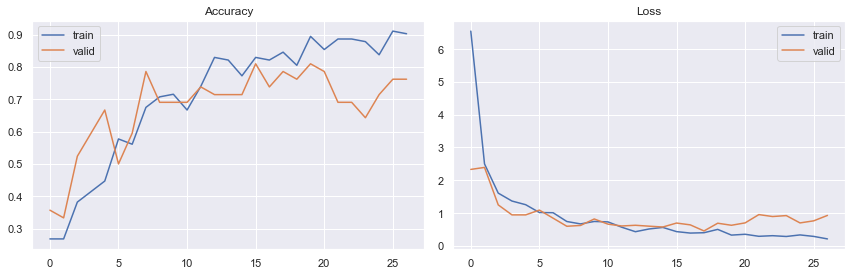

In [49]:
 modelTrained = compileAndTrain('ResNet152V2', 'm1', DATASET, model, train_generator, valid_generator, 
                                X_train, class_weights) 

(42, 224, 224, 3) (42, 4)
2/2 [==============================] - 9s 2s/step
total wrong validation predictions: 10


              precision    recall  f1-score   support

           0       0.60      0.82      0.69        11
           1       0.91      0.91      0.91        11
           2       1.00      1.00      1.00        10
           3       0.50      0.30      0.37        10

    accuracy                           0.76        42
   macro avg       0.75      0.76      0.74        42
weighted avg       0.75      0.76      0.75        42



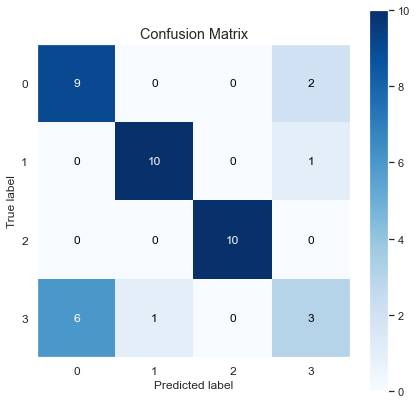

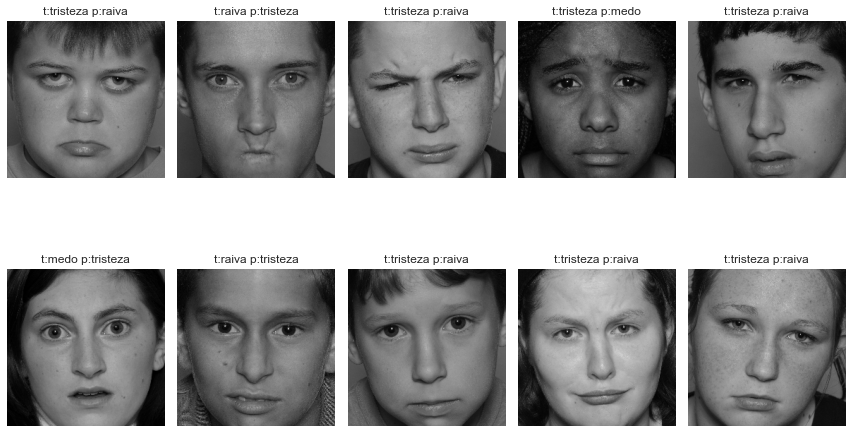

In [50]:
yhat = test_model('ResNet152V2', 'm1', DATASET, modelTrained, X_test, y_test, emotions_labels)

### ResNet152V2 - M2

In [51]:
model = createModel('ResNet152V2', img_height, img_width, modelType='m2', num_classes=4)

Model: "model_11"
_____________________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  Trainable  
 input_12 (InputLayer)       [(None, 224, 224, 3)]        0         []                            N          
                                                                                                             
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_12[0][0]']            N          
                                                                                                             
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           N          
                                                                                                             
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          N   

 conv2_block2_2_relu (Activ  (None, 56, 56, 64)           0         ['conv2_block2_2_bn[0][0]']   N          
 ation)                                                                                                      
                                                                                                             
 conv2_block2_3_conv (Conv2  (None, 56, 56, 256)          16640     ['conv2_block2_2_relu[0][0]   N          
 D)                                                                 ']                                       
                                                                                                             
 conv2_block2_out (Add)      (None, 56, 56, 256)          0         ['conv2_block1_out[0][0]',    N          
                                                                     'conv2_block2_3_conv[0][0]              
                                                                    ']                                       
          

 D)                                                                 0][0]']                                  
                                                                                                             
 conv3_block1_3_conv (Conv2  (None, 28, 28, 512)          66048     ['conv3_block1_2_relu[0][0]   N          
 D)                                                                 ']                                       
                                                                                                             
 conv3_block1_out (Add)      (None, 28, 28, 512)          0         ['conv3_block1_0_conv[0][0]   N          
                                                                    ',                                       
                                                                     'conv3_block1_3_conv[0][0]              
                                                                    ']                                       
          

                                                                     'conv3_block3_3_conv[0][0]              
                                                                    ']                                       
                                                                                                             
 conv3_block4_preact_bn (Ba  (None, 28, 28, 512)          2048      ['conv3_block3_out[0][0]']    N          
 tchNormalization)                                                                                           
                                                                                                             
 conv3_block4_preact_relu (  (None, 28, 28, 512)          0         ['conv3_block4_preact_bn[0]   N          
 Activation)                                                        [0]']                                    
                                                                                                             
 conv3_blo

 Activation)                                                        [0]']                                    
                                                                                                             
 conv3_block6_1_conv (Conv2  (None, 28, 28, 128)          65536     ['conv3_block6_preact_relu[   N          
 D)                                                                 0][0]']                                  
                                                                                                             
 conv3_block6_1_bn (BatchNo  (None, 28, 28, 128)          512       ['conv3_block6_1_conv[0][0]   N          
 rmalization)                                                       ']                                       
                                                                                                             
 conv3_block6_1_relu (Activ  (None, 28, 28, 128)          0         ['conv3_block6_1_bn[0][0]']   N          
 ation)   

                                                                                                             
 conv3_block8_1_relu (Activ  (None, 28, 28, 128)          0         ['conv3_block8_1_bn[0][0]']   N          
 ation)                                                                                                      
                                                                                                             
 conv3_block8_2_pad (ZeroPa  (None, 30, 30, 128)          0         ['conv3_block8_1_relu[0][0]   N          
 dding2D)                                                           ']                                       
                                                                                                             
 conv3_block8_2_conv (Conv2  (None, 14, 14, 128)          147456    ['conv3_block8_2_pad[0][0]'   N          
 D)                                                                 ]                                        
          

                                                                                                             
 conv4_block2_1_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block2_1_bn[0][0]']   N          
 ation)                                                                                                      
                                                                                                             
 conv4_block2_2_pad (ZeroPa  (None, 16, 16, 256)          0         ['conv4_block2_1_relu[0][0]   N          
 dding2D)                                                           ']                                       
                                                                                                             
 conv4_block2_2_conv (Conv2  (None, 14, 14, 256)          589824    ['conv4_block2_2_pad[0][0]'   N          
 D)                                                                 ]                                        
          

 conv4_block4_2_conv (Conv2  (None, 14, 14, 256)          589824    ['conv4_block4_2_pad[0][0]'   N          
 D)                                                                 ]                                        
                                                                                                             
 conv4_block4_2_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block4_2_conv[0][0]   N          
 rmalization)                                                       ']                                       
                                                                                                             
 conv4_block4_2_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block4_2_bn[0][0]']   N          
 ation)                                                                                                      
                                                                                                             
 conv4_blo

 ation)                                                                                                      
                                                                                                             
 conv4_block6_3_conv (Conv2  (None, 14, 14, 1024)         263168    ['conv4_block6_2_relu[0][0]   N          
 D)                                                                 ']                                       
                                                                                                             
 conv4_block6_out (Add)      (None, 14, 14, 1024)         0         ['conv4_block5_out[0][0]',    N          
                                                                     'conv4_block6_3_conv[0][0]              
                                                                    ']                                       
                                                                                                             
 conv4_blo

                                                                    ']                                       
                                                                                                             
 conv4_block9_preact_bn (Ba  (None, 14, 14, 1024)         4096      ['conv4_block8_out[0][0]']    N          
 tchNormalization)                                                                                           
                                                                                                             
 conv4_block9_preact_relu (  (None, 14, 14, 1024)         0         ['conv4_block9_preact_bn[0]   N          
 Activation)                                                        [0]']                                    
                                                                                                             
 conv4_block9_1_conv (Conv2  (None, 14, 14, 256)          262144    ['conv4_block9_preact_relu[   N          
 D)       

                                                                                                             
 conv4_block11_1_conv (Conv  (None, 14, 14, 256)          262144    ['conv4_block11_preact_relu   N          
 2D)                                                                [0][0]']                                 
                                                                                                             
 conv4_block11_1_bn (BatchN  (None, 14, 14, 256)          1024      ['conv4_block11_1_conv[0][0   N          
 ormalization)                                                      ]']                                      
                                                                                                             
 conv4_block11_1_relu (Acti  (None, 14, 14, 256)          0         ['conv4_block11_1_bn[0][0]'   N          
 vation)                                                            ]                                        
          

 conv4_block13_1_relu (Acti  (None, 14, 14, 256)          0         ['conv4_block13_1_bn[0][0]'   N          
 vation)                                                            ]                                        
                                                                                                             
 conv4_block13_2_pad (ZeroP  (None, 16, 16, 256)          0         ['conv4_block13_1_relu[0][0   N          
 adding2D)                                                          ]']                                      
                                                                                                             
 conv4_block13_2_conv (Conv  (None, 14, 14, 256)          589824    ['conv4_block13_2_pad[0][0]   N          
 2D)                                                                ']                                       
                                                                                                             
 conv4_blo

 2D)                                                                ']                                       
                                                                                                             
 conv4_block15_2_bn (BatchN  (None, 14, 14, 256)          1024      ['conv4_block15_2_conv[0][0   N          
 ormalization)                                                      ]']                                      
                                                                                                             
 conv4_block15_2_relu (Acti  (None, 14, 14, 256)          0         ['conv4_block15_2_bn[0][0]'   N          
 vation)                                                            ]                                        
                                                                                                             
 conv4_block15_3_conv (Conv  (None, 14, 14, 1024)         263168    ['conv4_block15_2_relu[0][0   N          
 2D)      

                                                                                                             
 conv4_block17_3_conv (Conv  (None, 14, 14, 1024)         263168    ['conv4_block17_2_relu[0][0   N          
 2D)                                                                ]']                                      
                                                                                                             
 conv4_block17_out (Add)     (None, 14, 14, 1024)         0         ['conv4_block16_out[0][0]',   N          
                                                                     'conv4_block17_3_conv[0][0              
                                                                    ]']                                      
                                                                                                             
 conv4_block18_preact_bn (B  (None, 14, 14, 1024)         4096      ['conv4_block17_out[0][0]']   N          
 atchNorma

                                                                                                             
 conv4_block20_preact_bn (B  (None, 14, 14, 1024)         4096      ['conv4_block19_out[0][0]']   N          
 atchNormalization)                                                                                          
                                                                                                             
 conv4_block20_preact_relu   (None, 14, 14, 1024)         0         ['conv4_block20_preact_bn[0   N          
 (Activation)                                                       ][0]']                                   
                                                                                                             
 conv4_block20_1_conv (Conv  (None, 14, 14, 256)          262144    ['conv4_block20_preact_relu   N          
 2D)                                                                [0][0]']                                 
          

 conv4_block22_1_conv (Conv  (None, 14, 14, 256)          262144    ['conv4_block22_preact_relu   N          
 2D)                                                                [0][0]']                                 
                                                                                                             
 conv4_block22_1_bn (BatchN  (None, 14, 14, 256)          1024      ['conv4_block22_1_conv[0][0   N          
 ormalization)                                                      ]']                                      
                                                                                                             
 conv4_block22_1_relu (Acti  (None, 14, 14, 256)          0         ['conv4_block22_1_bn[0][0]'   N          
 vation)                                                            ]                                        
                                                                                                             
 conv4_blo

 vation)                                                            ]                                        
                                                                                                             
 conv4_block24_2_pad (ZeroP  (None, 16, 16, 256)          0         ['conv4_block24_1_relu[0][0   N          
 adding2D)                                                          ]']                                      
                                                                                                             
 conv4_block24_2_conv (Conv  (None, 14, 14, 256)          589824    ['conv4_block24_2_pad[0][0]   N          
 2D)                                                                ']                                       
                                                                                                             
 conv4_block24_2_bn (BatchN  (None, 14, 14, 256)          1024      ['conv4_block24_2_conv[0][0   N          
 ormalizat

                                                                                                             
 conv4_block26_2_bn (BatchN  (None, 14, 14, 256)          1024      ['conv4_block26_2_conv[0][0   N          
 ormalization)                                                      ]']                                      
                                                                                                             
 conv4_block26_2_relu (Acti  (None, 14, 14, 256)          0         ['conv4_block26_2_bn[0][0]'   N          
 vation)                                                            ]                                        
                                                                                                             
 conv4_block26_3_conv (Conv  (None, 14, 14, 1024)         263168    ['conv4_block26_2_relu[0][0   N          
 2D)                                                                ]']                                      
          

 conv4_block28_3_conv (Conv  (None, 14, 14, 1024)         263168    ['conv4_block28_2_relu[0][0   N          
 2D)                                                                ]']                                      
                                                                                                             
 conv4_block28_out (Add)     (None, 14, 14, 1024)         0         ['conv4_block27_out[0][0]',   N          
                                                                     'conv4_block28_3_conv[0][0              
                                                                    ]']                                      
                                                                                                             
 conv4_block29_preact_bn (B  (None, 14, 14, 1024)         4096      ['conv4_block28_out[0][0]']   N          
 atchNormalization)                                                                                          
          

 conv4_block31_preact_bn (B  (None, 14, 14, 1024)         4096      ['conv4_block30_out[0][0]']   N          
 atchNormalization)                                                                                          
                                                                                                             
 conv4_block31_preact_relu   (None, 14, 14, 1024)         0         ['conv4_block31_preact_bn[0   N          
 (Activation)                                                       ][0]']                                   
                                                                                                             
 conv4_block31_1_conv (Conv  (None, 14, 14, 256)          262144    ['conv4_block31_preact_relu   N          
 2D)                                                                [0][0]']                                 
                                                                                                             
 conv4_blo

 2D)                                                                [0][0]']                                 
                                                                                                             
 conv4_block33_1_bn (BatchN  (None, 14, 14, 256)          1024      ['conv4_block33_1_conv[0][0   N          
 ormalization)                                                      ]']                                      
                                                                                                             
 conv4_block33_1_relu (Acti  (None, 14, 14, 256)          0         ['conv4_block33_1_bn[0][0]'   N          
 vation)                                                            ]                                        
                                                                                                             
 conv4_block33_2_pad (ZeroP  (None, 16, 16, 256)          0         ['conv4_block33_1_relu[0][0   N          
 adding2D)

                                                                                                             
 conv4_block35_2_pad (ZeroP  (None, 16, 16, 256)          0         ['conv4_block35_1_relu[0][0   N          
 adding2D)                                                          ]']                                      
                                                                                                             
 conv4_block35_2_conv (Conv  (None, 14, 14, 256)          589824    ['conv4_block35_2_pad[0][0]   N          
 2D)                                                                ']                                       
                                                                                                             
 conv4_block35_2_bn (BatchN  (None, 14, 14, 256)          1024      ['conv4_block35_2_conv[0][0   N          
 ormalization)                                                      ]']                                      
          

 conv5_block1_2_conv (Conv2  (None, 7, 7, 512)            2359296   ['conv5_block1_2_pad[0][0]'   N          
 D)                                                                 ]                                        
                                                                                                             
 conv5_block1_2_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block1_2_conv[0][0]   N          
 rmalization)                                                       ']                                       
                                                                                                             
 conv5_block1_2_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block1_2_bn[0][0]']   N          
 ation)                                                                                                      
                                                                                                             
 conv5_blo

 conv5_block3_2_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block3_2_conv[0][0]   N          
 rmalization)                                                       ']                                       
                                                                                                             
 conv5_block3_2_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_2_bn[0][0]']   Y          
 ation)                                                                                                      
                                                                                                             
 conv5_block3_3_conv (Conv2  (None, 7, 7, 2048)           1050624   ['conv5_block3_2_relu[0][0]   Y          
 D)                                                                 ']                                       
                                                                                                             
 conv5_blo

Epoch 1/30
6/6 [==============================] - 38s 6s/step - loss: 1.7524 - accuracy: 0.4065 - val_loss: 1.3376 - val_accuracy: 0.3333 - lr: 1.0000e-04
Epoch 2/30
6/6 [==============================] - 31s 5s/step - loss: 0.7923 - accuracy: 0.7317 - val_loss: 1.2379 - val_accuracy: 0.4286 - lr: 1.0000e-04
Epoch 3/30
6/6 [==============================] - 31s 6s/step - loss: 0.6395 - accuracy: 0.8049 - val_loss: 1.1112 - val_accuracy: 0.4048 - lr: 1.0000e-04
Epoch 4/30
6/6 [==============================] - 31s 6s/step - loss: 0.5355 - accuracy: 0.8211 - val_loss: 1.0990 - val_accuracy: 0.4286 - lr: 1.0000e-04
Epoch 5/30
6/6 [==============================] - 31s 5s/step - loss: 0.3036 - accuracy: 0.8943 - val_loss: 1.1356 - val_accuracy: 0.4048 - lr: 1.0000e-04
Epoch 6/30
6/6 [==============================] - 32s 5s/step - loss: 0.4843 - accuracy: 0.8455 - val_loss: 1.1340 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 7/30
6/6 [==============================] - 32s 5s/step - loss: 

/home/s462321333/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


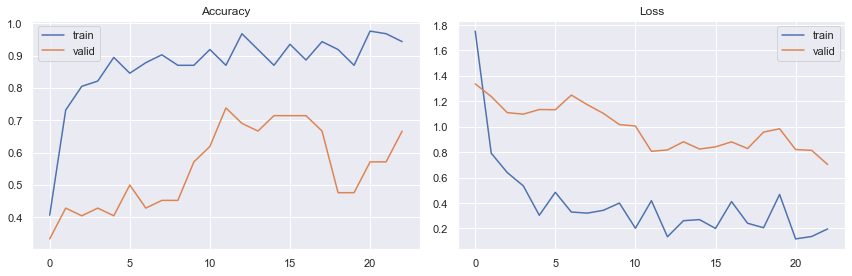

In [52]:
 modelTrained = compileAndTrain('ResNet152V2', 'm2', DATASET, model, train_generator, valid_generator, 
                                X_train, class_weights) 

(42, 224, 224, 3) (42, 4)
2/2 [==============================] - 9s 2s/step
total wrong validation predictions: 12


              precision    recall  f1-score   support

           0       0.58      0.64      0.61        11
           1       0.89      0.73      0.80        11
           2       0.77      1.00      0.87        10
           3       0.62      0.50      0.56        10

    accuracy                           0.71        42
   macro avg       0.72      0.72      0.71        42
weighted avg       0.72      0.71      0.71        42



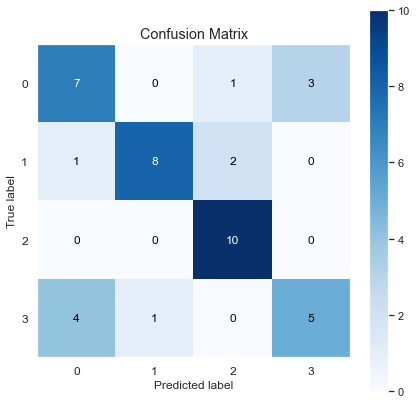

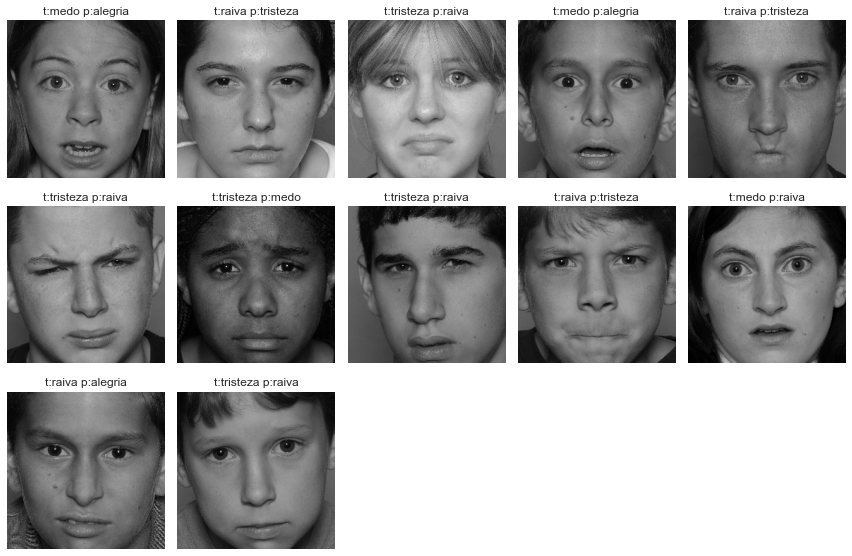

In [53]:
yhat = test_model('ResNet152V2', 'm2', DATASET, modelTrained, X_test, y_test, emotions_labels)

### VGG16 - M1

In [54]:
model = createModel('VGG16', img_height, img_width, modelType='m1', num_classes=4)

Model: "model_12"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         N          
                                                                            
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      N          
                                                                            
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     N          
                                                                            
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         N          
                                                                            
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     N          
                                                                            
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147

Epoch 1/30
6/6 [==============================] - 43s 7s/step - loss: 2.8134 - accuracy: 0.2276 - val_loss: 1.4828 - val_accuracy: 0.2619 - lr: 1.0000e-04
Epoch 2/30
6/6 [==============================] - 42s 7s/step - loss: 1.6170 - accuracy: 0.2276 - val_loss: 1.4596 - val_accuracy: 0.1667 - lr: 1.0000e-04
Epoch 3/30
6/6 [==============================] - 42s 7s/step - loss: 1.4363 - accuracy: 0.2927 - val_loss: 1.3690 - val_accuracy: 0.1905 - lr: 1.0000e-04
Epoch 4/30
6/6 [==============================] - 42s 7s/step - loss: 1.3366 - accuracy: 0.3577 - val_loss: 1.3026 - val_accuracy: 0.3571 - lr: 1.0000e-04
Epoch 5/30
6/6 [==============================] - 42s 8s/step - loss: 1.2889 - accuracy: 0.4065 - val_loss: 1.1472 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 6/30
6/6 [==============================] - 42s 7s/step - loss: 1.0909 - accuracy: 0.5935 - val_loss: 1.0032 - val_accuracy: 0.5714 - lr: 1.0000e-04
Epoch 7/30
6/6 [==============================] - 42s 7s/step - loss: 

/home/s462321333/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


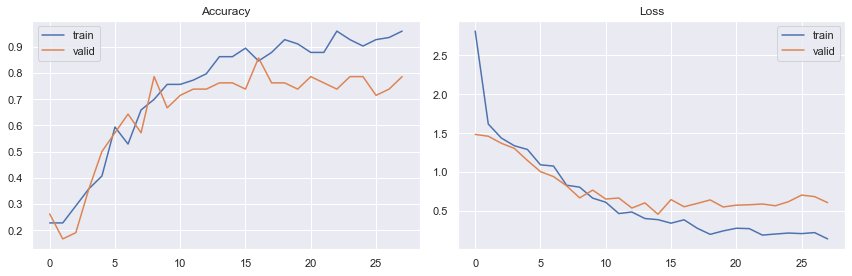

In [55]:
 modelTrained = compileAndTrain('VGG16', 'm1', DATASET, model, train_generator, valid_generator, 
                                X_train, class_weights) 

(42, 224, 224, 3) (42, 4)
2/2 [==============================] - 10s 2s/step
total wrong validation predictions: 10


              precision    recall  f1-score   support

           0       0.80      0.36      0.50        11
           1       0.85      1.00      0.92        11
           2       1.00      1.00      1.00        10
           3       0.50      0.70      0.58        10

    accuracy                           0.76        42
   macro avg       0.79      0.77      0.75        42
weighted avg       0.79      0.76      0.75        42



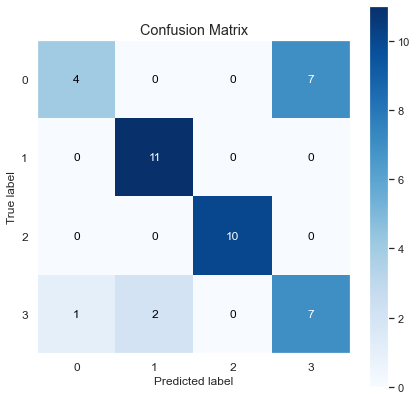

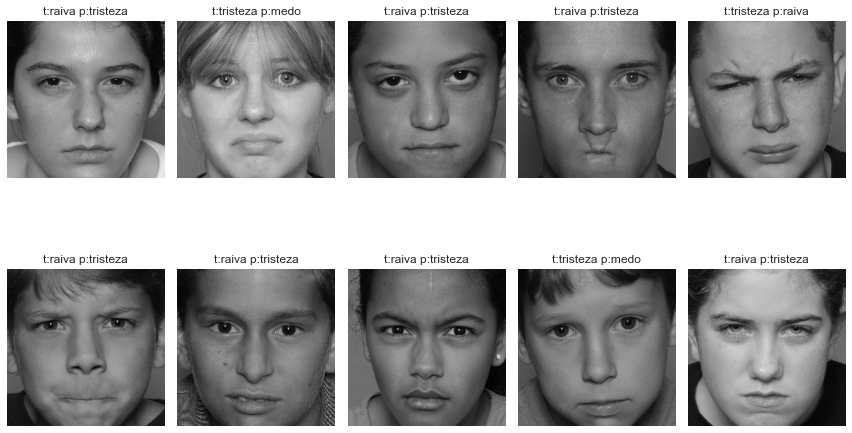

In [56]:
yhat = test_model('VGG16', 'm1', DATASET, modelTrained, X_test, y_test, emotions_labels)

### VGG16 - M2

In [57]:
model = createModel('VGG16', img_height, img_width, modelType='m2', num_classes=4)

Model: "model_13"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         N          
                                                                            
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      N          
                                                                            
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     N          
                                                                            
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         N          
                                                                            
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     N          
                                                                            
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147

Epoch 1/30
6/6 [==============================] - 42s 7s/step - loss: 1.1358 - accuracy: 0.5203 - val_loss: 1.3211 - val_accuracy: 0.4524 - lr: 1.0000e-04
Epoch 2/30
6/6 [==============================] - 42s 7s/step - loss: 0.5846 - accuracy: 0.7642 - val_loss: 1.2131 - val_accuracy: 0.4524 - lr: 1.0000e-04
Epoch 3/30
6/6 [==============================] - 42s 8s/step - loss: 0.3907 - accuracy: 0.8293 - val_loss: 1.1642 - val_accuracy: 0.4524 - lr: 1.0000e-04
Epoch 4/30
6/6 [==============================] - 42s 7s/step - loss: 0.3571 - accuracy: 0.8537 - val_loss: 1.1456 - val_accuracy: 0.5714 - lr: 1.0000e-04
Epoch 5/30
6/6 [==============================] - 42s 7s/step - loss: 0.3220 - accuracy: 0.8780 - val_loss: 1.1499 - val_accuracy: 0.5476 - lr: 1.0000e-04
Epoch 6/30
6/6 [==============================] - 42s 7s/step - loss: 0.3699 - accuracy: 0.8537 - val_loss: 1.1631 - val_accuracy: 0.5952 - lr: 1.0000e-04
Epoch 7/30
6/6 [==============================] - 42s 7s/step - loss: 

/home/s462321333/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


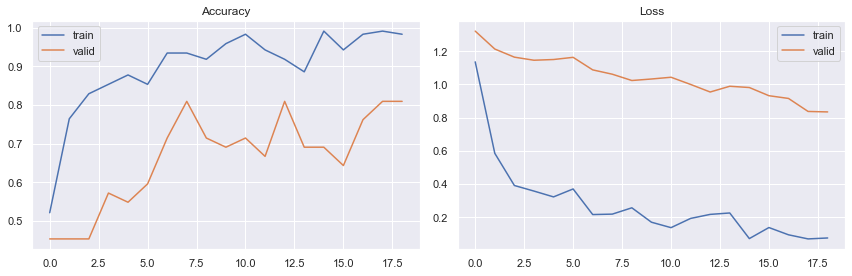

In [58]:
 modelTrained = compileAndTrain('VGG16', 'm2', DATASET, model, train_generator, valid_generator, 
                                X_train, class_weights) 

(42, 224, 224, 3) (42, 4)
2/2 [==============================] - 10s 2s/step
total wrong validation predictions: 10


              precision    recall  f1-score   support

           0       0.71      0.45      0.56        11
           1       0.79      1.00      0.88        11
           2       1.00      1.00      1.00        10
           3       0.55      0.60      0.57        10

    accuracy                           0.76        42
   macro avg       0.76      0.76      0.75        42
weighted avg       0.76      0.76      0.75        42



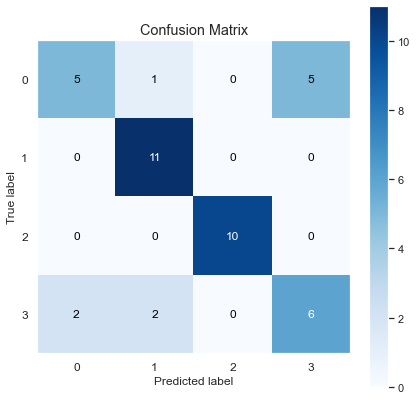

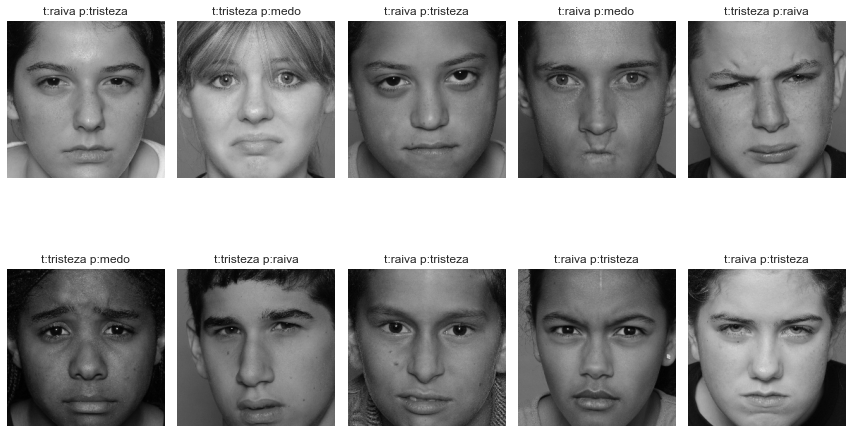

In [59]:
yhat = test_model('VGG16', 'm2', DATASET, modelTrained, X_test, y_test, emotions_labels)